In [1]:
import jax
import numpy
import jax.numpy as np
#import numpy as np
from jax import random, grad, vmap, jit, hessian, lax
from jax.example_libraries import optimizers
from jax.config import config
from jax.numpy import index_exp as index
from jax.flatten_util import ravel_pytree
import itertools
from functools import partial
from torch.utils import data
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import scipy

from scipy.interpolate import griddata
import equinox as eqx
import optax

from IPython import display
import time
%matplotlib inline

In [2]:
import jax
jax.default_backend()

'gpu'

In [3]:
# Use double precision to generate data (due to GP sampling)
#https://github.com/PredictiveIntelligenceLab/Physics-informed-DeepONets/blob/main/Diffusion-reaction/PI_DeepONet_DR.ipynb
def RBF(x1, x2, params):
    output_scale, lengthscales = params
    diffs = np.expand_dims(x1 / lengthscales, 1) - \
            np.expand_dims(x2 / lengthscales, 0)
    r2 = np.sum(diffs**2, axis=2)
    return output_scale * np.exp(-0.5 * r2)


In [4]:
# Source term generator for BHT equation
def gaussian_generator(key, mag_scale, x):

    # key = jax.random.PRNGKey(2)
    subkeys = jax.random.split(key, 3)
    zeta = jax.random.uniform(subkeys[0], minval=1, maxval=mag_scale)
    stdev = jax.random.uniform(subkeys[1], minval=0.1, maxval=0.2)
    mean = jax.random.uniform(subkeys[2], minval=0.1, maxval=0.9)
    # Define the range of x values
    # x = jnp.linspace(0, 1, 100)

    # Calculate the corresponding probability density values (bell curve)
    output_dist = np.zeros_like(x)
    output_dist = zeta*(1.0 / (stdev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / stdev) ** 2)
    # output_dist = np.clip(output_dist, 0, mag_scale*2)

    return output_dist

def source1(num_curves, key, mag_scale, x):
    subkeys = random.split(key, num_curves)
    y = np.zeros_like(x)
    for i in range(num_curves):
        y += gaussian_generator(subkeys[i], mag_scale, x)
    return y

In [5]:
def bessel_beam_profile(key, mag_scale, r):
    """
    Generate a Bessel beam profile.

    Parameters:
    - r: Radial distance from the beam axis
    - w0: Waist of the Bessel beam
    - m: Order of the Bessel function

    Returns:
    - Intensity profile of the Bessel beam at the given radial distance
    """
    # Set Bessel beam parameters
    subkeys = jax.random.split(key, 3)
    w0 = jax.random.uniform(subkeys[2], minval=0.2, maxval=0.4)  # Waist of the Bessel beam
    m = 4    # Order of the Bessel function
    w = w0 * np.maximum(0.0, np.sqrt(1 + (m * r / w0)**2))  # Bessel beam width
    intensity = np.zeros_like(r)
    intensity = mag_scale*(2 * jax.scipy.special.bessel_jn(m * r / w0, v=m) / (m * r / w0))**2 # Bessel beam intensity
    return (intensity * np.exp(-(r / w)**2)).T[:,-1]  # Gaussian envelope



# # Plot the Bessel beam profile
# plt.plot(r, intensity_profile, label=f'Bessel Beam (m={m})')
# plt.xlabel('Radial Distance')
# plt.ylabel('Intensity')
# plt.title('Bessel Beam Profile')
# plt.legend()
# plt.show()

def source2(num_curves, key, mag_scale, x):
    subkeys = random.split(key, num_curves)
    y = np.zeros_like(x)
    for i in range(num_curves):
        y += bessel_beam_profile(subkeys[i], mag_scale, x)
    return y

In [6]:
# FDM for 1D BHT equation using Crank Nicolson discretization scheme and TDMA solver

def solve_ADR(key, Nx, Nt, P, mag_scale, length_scale, on_off):
    xmin, xmax = 0, 1
    tmin, tmax = 0, 1
    k = 0.527
    v = 0.1
    rho = 1.04e-6
    cp = 3.65e6
    rho_b = 1.06e-6
    cb = 3.6e6
    wb = 8.5e-3
    T_a = 36.7 
    qm = 9.7e-3
    T_init = 37
    T_bc_left = 25
    T_bc_right = 37
    g = lambda u: 0.01*u ** 2
    dg = lambda u: 0.02 * u
    u0 = lambda x: np.ones_like(x)*T_init

    # Generate subkeys
    subkeys = random.split(key, 3)

    # Generate a GP sample
    N = 512
    gp_params = (100000, length_scale)
    jitter = 1e-5
    X = np.linspace(xmin, xmax, N)[:,None]
    K = RBF(X, X, gp_params)
    L = np.linalg.cholesky(K + jitter*np.eye(N))
    gp_sample = np.dot(L, random.normal(subkeys[0], (N,)))
    # Create a callable interpolation function
    f_fn = lambda x: np.interp(x, X.flatten(), gp_sample)
    
    

    # Create grid
    x = np.linspace(xmin, xmax, Nx)
    t = np.linspace(tmin, tmax, Nt)
    h = x[1] - x[0]
    dt = t[1] - t[0]
    h2 = h ** 2

    # Compute the source term

    # f = f_fn(x)
    num_curves = numpy.random.randint(1, 5) # 1 to 4 curves
    # f = source1(num_curves, subkeys[0], mag_scale, x) + on_off*abs(100*f_fn(x))
    f = source1(num_curves, subkeys[0], mag_scale, x)

    # IC
    u = np.ones((Nx, Nt))*T_init
    u = u.at[:,0].set(u0(x))

    # Set constants to solve Au=d equation
    a = 1 + (k*dt)/(rho*cp*h2)
    b = (-1*k*dt)/(2*rho*cp*h2)
    c = b
    bp = (rho_b*cb*wb*dt)/(rho*cp)
    z = (rho_b*cb*wb*T_a + qm + f)*(dt/(rho*cp))
    # RHS
    d = np.zeros((Nx))
    # LHS 'A' matrix
    lower = np.zeros_like(d)
    lower = lower.at[1:-1].set(c) #dl[0] = 0 and BC
    lower = lower.T
    upper = np.zeros_like(d)
    upper = upper.at[1:-1].set(b)
    upper = upper.T
    main = np.ones_like(d)
    main = main.at[1:-1].set(a) #du[m - 1] = 0 and BC
    main = main.T

    for i in range(1, Nt):
        d = d.at[1:-1].set(-1*b*u[2:Nx,i-1] + (1 + b + c - bp)*u[1:Nx-1,i-1] - c*u[0:Nx-2,i-1]) + z
        d = d.at[0].set(T_bc_left)
        d = d.at[-1].set(T_bc_right)

        u_updated = jax.lax.linalg.tridiagonal_solve(lower, main, upper, np.expand_dims(d,1)) 
        u = u.at[:,i].set(u_updated.squeeze())

    
    UU = u

    u = f
    # UU_mean = T_a # np.mean(u)
    # UU_std = np.std(UU)
    # UU_scaled = (UU - UU_mean) / UU_std

    # u_scaled = u / UU_std

    # u = u_scaled
    # UU = UU_scaled

    idx = random.randint(subkeys[1], (P,2), 0, max(Nx,Nt))
    y = np.concatenate([x[idx[:,0]][:,None], t[idx[:,1]][:,None]], axis = 1)
    s = UU[idx[:,0], idx[:,1]]


    return (x, t, UU), (u, y, s)

In [117]:
# Plots
def plot(X,T,f):
  fig = plt.figure(figsize=(7,5))
  plt.pcolor(X,T,f, cmap='rainbow')
  plt.colorbar()
  plt.xlabel('')
  plt.ylabel('')
  plt.title('')
  plt.tight_layout()


In [7]:
# GRF length scale
mag_scale = 100
length_scale = 0.1
on_off = 1 # 0: turns off GRF, 1: turns on GRF
N = 5000 # number of input samples
# Resolution of the solution (Grid of 100x100)
Nx = 100
Nt = 100
# Select the number of sensors
m = Nx   # number of input sensors
P_train = 300 # number of output sensors, 100 for each side
Q_train = 100  # number of collocation points for each input sample

In [50]:
config.update("jax_enable_x64", True)
# Numerical solution
key = random.PRNGKey(7006)
(x, t, UU), (u, y, s) = solve_ADR(key, Nx, Nt, P_train, mag_scale, length_scale, on_off)

In [52]:
UU.shape

(100, 100)

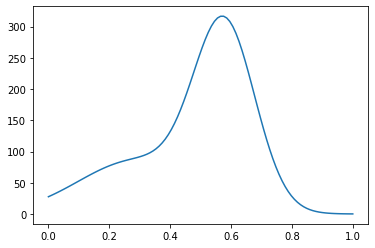

In [11]:

plt.plot(x,u)

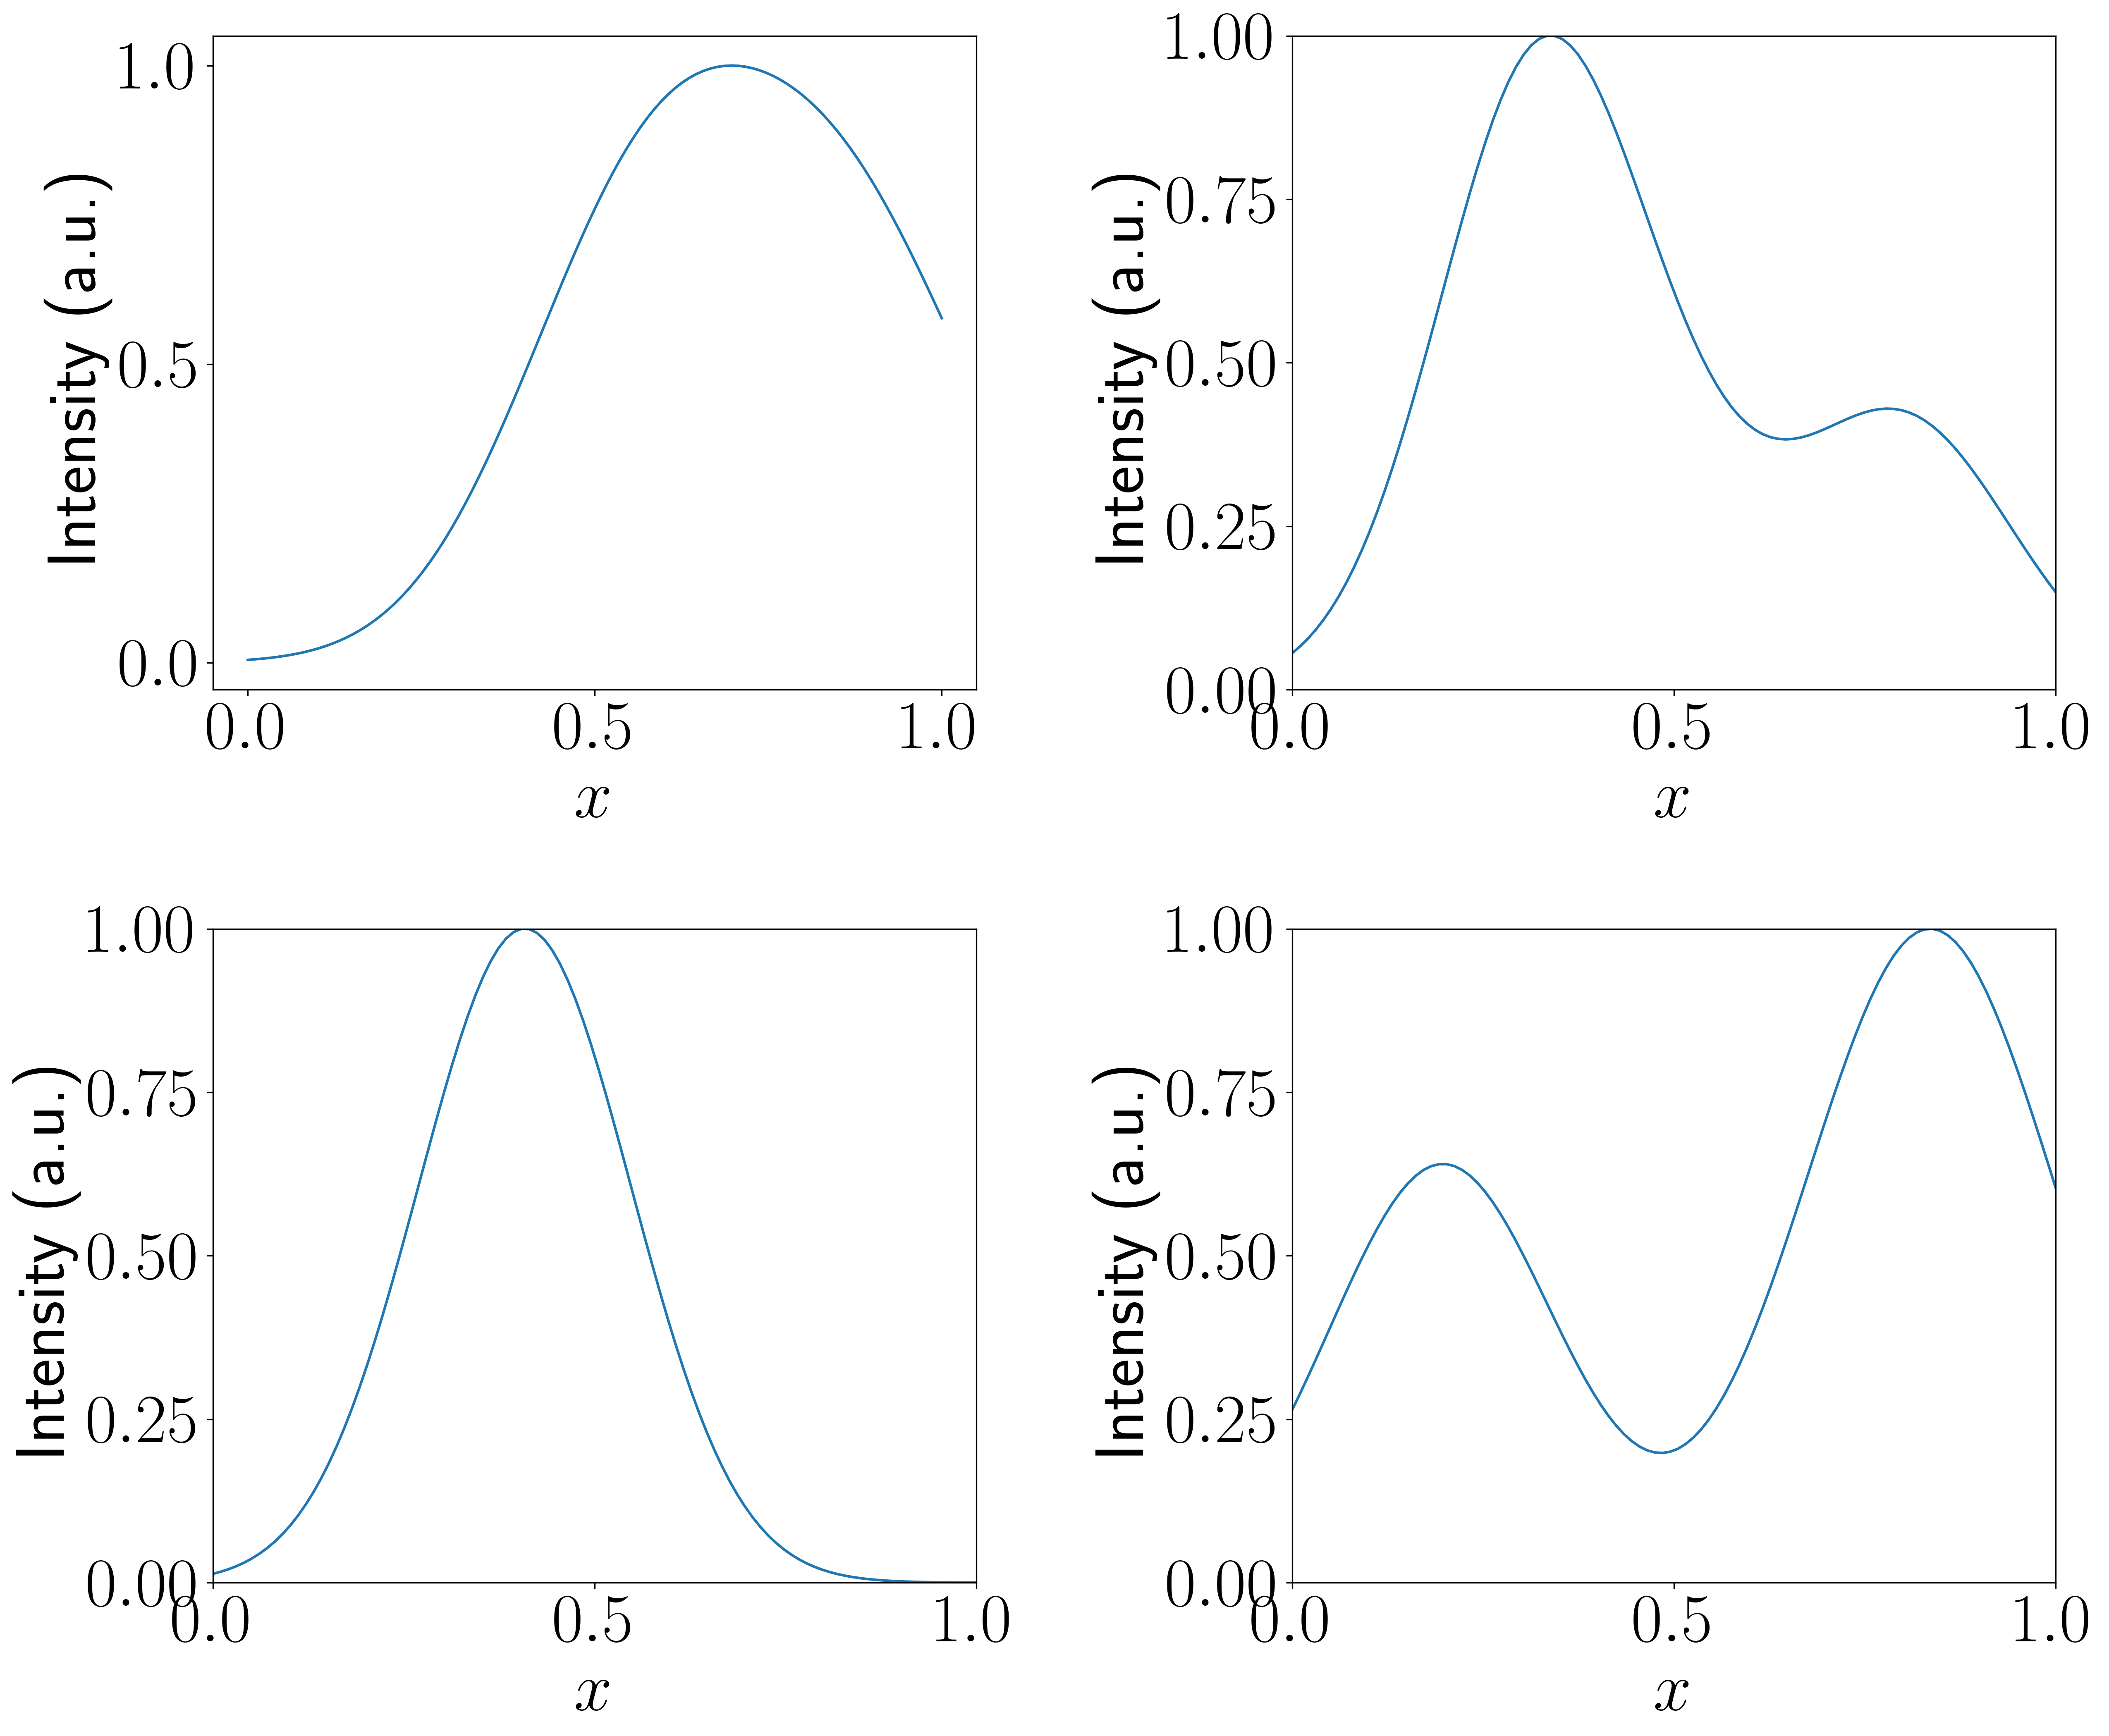

In [15]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 40})

fig = plt.figure(figsize=(18,15), dpi=300)

(x, t, UU), (u, y, s) = solve_ADR(random.PRNGKey(1), Nx, Nt, P_train, mag_scale, length_scale, on_off)
plt.subplot(2,2,1)
plt.plot(x,u/np.max(u))
plt.xlabel('$x$')
plt.ylabel('Intensity (a.u.)')
plt.tight_layout()

(x, t, UU), (u, y, s) = solve_ADR(random.PRNGKey(2), Nx, Nt, P_train, mag_scale, length_scale, on_off)
plt.subplot(2,2,2)
plt.plot(x,u/np.max(u))
plt.xlabel('$x$')
plt.ylabel('Intensity (a.u.)')
plt.xlim((0,1))
plt.ylim((0,1))
plt.tight_layout()

(x, t, UU), (u, y, s) = solve_ADR(random.PRNGKey(30), Nx, Nt, P_train, mag_scale, length_scale, on_off)
plt.subplot(2,2,3)
plt.plot(x,u/np.max(u))
plt.xlabel('$x$')
plt.ylabel('Intensity (a.u.)')
plt.xlim((0,1))
plt.ylim((0,1))
plt.tight_layout()

(x, t, UU), (u, y, s) = solve_ADR(random.PRNGKey(40), Nx, Nt, P_train, mag_scale, length_scale, on_off)
plt.subplot(2,2,4)
plt.plot(x,u/np.max(u))
plt.xlabel('$x$')
plt.ylabel('Intensity (a.u.)')
plt.xlim((0,1))
plt.ylim((0,1))
plt.tight_layout()

plt.show()

In [76]:
np.max(UU)

Array(106.52370114, dtype=float64)

<Figure size 504x360 with 0 Axes>

Text(0.5, 1.0, '')

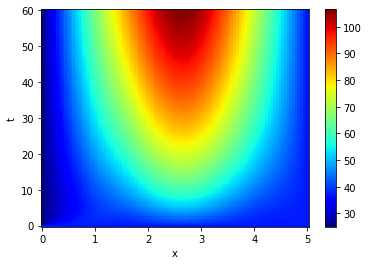

In [77]:
fig = plt.figure(figsize=(7,5))
plt.show()
x = np.linspace(0, 5, Nx)
t = np.linspace(0, 60, Nt)
XX, TT = np.meshgrid(x, t)
plt.xlabel('x')
plt.ylabel('t')
cp = plt.pcolor(XX,TT,UU.T,cmap='jet')
fig.colorbar(cp)
plt.title('')
#plt.tight_layout()

In [83]:
# For pure DeepONet only

# Geneate training data corresponding to one input sample
def generate_one_training_data(key, P, Q):
    # Numerical solution
    (x, t, UU), (u, y, s) = solve_ADR(key, Nx, Nt, P, mag_scale=100, length_scale=0.1, on_off=1)
    # Geneate subkeys
    subkeys = random.split(key, 4)
    u = np.tile(u, (P, 1))

    # Sample collocation points
    x_r_idx= random.choice(subkeys[2], np.arange(Nx), shape = (Q,1))
    x_r = x[x_r_idx]
    t_r = random.uniform(subkeys[3], minval = 0, maxval = 1, shape = (Q,1))

    # Training data for the PDE residual
    '''For the operator'''
    u_r_train = np.tile(u, (Q,1)) / mag_scale
    y_r_train = np.hstack([x_r, t_r])
    '''For the function'''
    f_r_train = u[x_r_idx] / mag_scale
    # UU_train = UU 
    return u, y, s, u_r_train, y_r_train, f_r_train

In [80]:
# For pure DeepONet only

# Geneate training data corresponding to N input sample
def generate_training_data(key, N, P, Q):
    config.update("jax_enable_x64", True)
    keys = random.split(key, N)
    u_train, y_train, s_train, u_r_train, y_r_train, f_r_train = vmap(generate_one_training_data, (0, None))(keys, P, Q)

    u_train = np.float32(u_train.reshape(N * P, -1))
    y_train = np.float32(y_train.reshape(N * P, -1))
    s_train = np.float32(s_train.reshape(N * P, -1))

    u_res_train = np.float32(u_r_train.reshape(N * Q_train,-1))
    y_res_train = np.float32(y_r_train.reshape(N * Q_train,-1))
    f_res_train = np.float32(f_r_train.reshape(N * Q_train,-1))

    config.update("jax_enable_x64", False)
    return u_train, y_train, s_train, u_res_train, y_res_train, f_res_train

In [52]:
# Generate training data corresponding to one input sample
def generate_one_training_data(key, P, Q):
    # Numerical solution
    (x, t, UU), (u, y, s) = solve_ADR(key, Nx, Nt, P, mag_scale=100, length_scale=0.1, on_off=1)

    # Geneate subkeys
    subkeys = random.split(key, 4)

    # Sample points from the boundary and the inital conditions
    # Here we regard the initial condition as a special type of boundary conditions
    x_bc1 = np.zeros((P // 6, 1))
    x_bc2 = np.ones((P // 6, 1))
    x_bc3 = random.uniform(key = subkeys[0], shape = (P // 6, 1))
    x_bcs = np.vstack((x_bc1, x_bc2, x_bc3))

    t_bc1 = random.uniform(key = subkeys[1], shape = (P//6 * 2, 1))
    t_bc2 = np.zeros((P//6, 1))
    t_bcs = np.vstack([t_bc1, t_bc2])

    # Training data for BC and IC
    u_train = np.tile(u, (P,1)) / mag_scale
    y_train_bc = np.hstack([x_bcs, t_bcs])
    y_train = np.vstack((y_train_bc, y[P//2:P]))
    s_train = s
    s_train = s.at[:P//6].set(25)
    s_train = s.at[P//6:P//6 * 2].set(37)
    s_train = s.at[P//6 * 2:P//2].set(37)
    # s_train = s_train.at[P//2:P].set(s[P//2:P])

    # Sample collocation points
    x_r_idx= random.choice(subkeys[2], np.arange(Nx), shape = (Q,1))
    x_r = x[x_r_idx]
    t_r = random.uniform(subkeys[3], minval = 0, maxval = 1, shape = (Q,1))

    # Training data for the PDE residual
    '''For the operator'''
    u_r_train = np.tile(u, (Q,1)) / mag_scale
    y_r_train = np.hstack([x_r, t_r])
    '''For the function'''
    f_r_train = u[x_r_idx] / mag_scale
    # UU_train = UU 
    return u_train, y_train, s_train, u_r_train, y_r_train, f_r_train

In [59]:
# For pure DeepONet only

# Geneate test data corresponding to one input sample
def generate_one_test_data_groundtruth(key, P):
    Nx = P
    Nt = P
    (x, t, UU), (u, y, s) = solve_ADR(key, Nx , Nt, P, mag_scale=100, length_scale=0.1, on_off=1)

    XX, TT = np.meshgrid(x, t)

    u_test = np.tile(u, (P**2, 1))
    y_test = np.hstack([XX.flatten()[:,None], TT.flatten()[:,None]])
    s_test = UU.T.flatten()

    return u_test, y_test, s_test

In [60]:
# for pure DeepONet only

# Geneate test data corresponding to N input sample
def generate_test_data_groundtruth(key, N, P):

    config.update("jax_enable_x64", True)
    keys = random.split(key, N)

    u_test, y_test, s_test = vmap(generate_one_test_data_groundtruth, (0, None))(keys, P)

    u_test = np.float32(u_test.reshape(N * P**2, -1))
    y_test = np.float32(y_test.reshape(N * P**2, -1))
    s_test = np.float32(s_test.reshape(N * P**2, -1))

    config.update("jax_enable_x64", False)
    return u_test, y_test, s_test

In [81]:
key = random.PRNGKey(0)

# GRF length scale
length_scale = 0.2

# Resolution of the solution
Nx = 100
Nt = 100

N = 2000 # number of input samples
m = Nx   # number of input sensors
P_train = 300 # number of output sensors
Q_train = 100

u_train, y_train, s_train, u_res_train, y_res_train, f_res_train = generate_training_data(key, N, P_train, Q_train)

ValueError: vmap in_axes specification must be a tree prefix of the corresponding value, got specification (0, None) for value tree PyTreeDef((*, *, *)).

In [84]:
# GRF length scale
length_scale = 0.2

# Resolution of the solution
Nx = 100
Nt = 100

N = 2000 # number of input samples
m = Nx   # number of input sensors
P_train = 300 # number of output sensors

# Select N keys to create N Functions
key = random.PRNGKey(1510)
keys = random.split(key, N)
u_train, y_train, s_train, u_r_train, y_r_train, f_r_train = generate_one_training_data(key, P_train, Q_train)

In [85]:
config.update("jax_enable_x64", True)
u_train, y_train, s_train, u_r_train, y_r_train, f_r_train = vmap(generate_one_training_data, (0, None, None))(keys, P_train, Q_train)

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 48000000000 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:  457.76MiB
              constant allocation:         0B
        maybe_live_out allocation:   44.70GiB
     preallocated temp allocation:         0B
                 total allocation:   45.15GiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 44.70GiB
		Operator: op_name="jit(broadcast_in_dim)/jit(main)/broadcast_in_dim[shape=(2000, 100, 300, 1, 100) broadcast_dimensions=(0, 2, 3, 4)]" source_file="<ipython-input-83-7f4703988274>" source_line=18
		XLA Label: fusion
		Shape: f64[2000,100,300,1,100]
		==========================

	Buffer 2:
		Size: 457.76MiB
		Entry Parameter Subshape: f64[2000,300,1,100]
		==========================



: 

In [68]:
# Reshape the data
u_bcs_train = np.float32(u_train.reshape(N * P_train,-1))
y_bcs_train = np.float32(y_train.reshape(N * P_train,-1))
s_bcs_train = np.float32(s_train.reshape(N * P_train,-1))

u_res_train = np.float32(u_r_train.reshape(N * Q_train,-1))
y_res_train = np.float32(y_r_train.reshape(N * Q_train,-1))
f_res_train = np.float32(f_r_train.reshape(N * Q_train,-1))

In [69]:
s_bcs_train.shape

(3000000, 1)

In [13]:
config.update("jax_enable_x64", False)

In [14]:
# Data generator
class DataGenerator(data.Dataset):
    def __init__(self, u, y, s,
                 batch_size=32, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.u = u # input sample
        self.y = y # location
        self.s = s # labeled data evaluated at y (solution measurements, BC/IC conditions, etc.)

        self.N = u.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, outputs = self.__data_generation(subkey)
        return inputs, outputs

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        s = self.s[idx,:]
        y = self.y[idx,:]
        u = self.u[idx,:]
        # Construct batch
        inputs = (u, y)
        outputs = s
        return inputs, outputs

In [1013]:
# Define the neural net
def MLP1(layers, activation=relu):
  ''' Vanilla MLP'''
  def init(rng_key):
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          b = np.zeros(d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return params
  def apply(params, inputs):
      for W, b in params[:-1]:
          #print(inputs.shape)
          #print(W.shape)
          outputs = np.dot(inputs, W) + b
          inputs = activation(outputs)
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      return outputs
  return init, apply

In [319]:
class FCN(eqx.Module):
    # layers: list
    norm1: eqx.nn.BatchNorm
    norm2: eqx.nn.BatchNorm
    linear1: eqx.nn.Linear
    linear2: eqx.nn.Linear
    linear3: eqx.nn.Linear
    out: eqx.nn.Linear
    # weights: jax.Array
    # bias: jax.Array

    def __init__(self, input_features, output_features, key):
        # key1 = random.PRNGKey(key)
        subkeys = random.split(key,6)
        # self.layers = [eqx.nn.Linear(in_features=input_features, out_features=50, key=subkeys[0]),
        #                eqx.nn.Linear(in_features=50, out_features=50, key=subkeys[1]),
        #                eqx.nn.Linear(in_features=50, out_features=50, key=subkeys[2]),
        #                eqx.nn.Linear(in_features=50, out_features=50, key=subkeys[3]),
        #                eqx.nn.Linear(in_features=50, out_features=output_features, key=subkeys[4])]

        self.norm1 = eqx.nn.BatchNorm(input_size=input_features, axis_name="batches")
        self.norm2 = eqx.nn.BatchNorm(input_size=50, axis_name="batch")
        self.linear1 = eqx.nn.Linear(in_features=50, out_features=50, key=subkeys[0])
        self.linear2 = eqx.nn.Linear(in_features=50, out_features=50, key=subkeys[1])
        self.linear3 = eqx.nn.Linear(in_features=50, out_features=50, key=subkeys[2])
        self.out = eqx.nn.Linear(in_features=50, out_features=output_features, key=subkeys[3])
        

def initializer(weight: jax.Array, key) -> jax.Array:
    init = jax.nn.initializers.glorot_normal() # Xavier init of weights
    out = init(key, weight.shape)
    return out

def MLP(model, init_fn, key): # function to replace FCN random weights with Xavier init weights
    is_linear = lambda x: isinstance(x, eqx.nn.Linear)
    get_weights = lambda m: [x.weight
                            for x in jax.tree_util.tree_leaves(m, is_leaf=is_linear)
                            if is_linear(x)]
    weights = get_weights(model)
    new_weights = [init_fn(weight, subkey)
                    for weight, subkey in zip(weights, jax.random.split(key, len(weights)))]
    return eqx.tree_at(get_weights, model, new_weights)

class ANN(FCN):

    def __init__(self, in_features, out_features, key):
        super().__init__(in_features, out_features, key)
    def init(in_features, out_features, key, init=initializer):
        key1 = random.PRNGKey(key)
        subkeys = random.split(key1,2)
        output =  MLP(FCN(in_features, out_features, subkeys[0]), init, subkeys[1])
        # self.weight = output.layers[:].weight
        # self.bias = output.layers[:].bias
        return output
    def apply(self, x, state):
        # for layer in output.layers[:-1]:
        #     x = jax.nn.tanh(layer(x))
        # out = output.layers[-1](x)
        # #print(out.shape)
        x, state = self.norm1(x, state)
        x = self.linear1(x)
        x, state = self.norm2(x, state)
        x = jax.nn.relu(self.linear2(x))
        x = jax.nn.relu(self.linear3(x))
        output = self.out(x)
        return output, state

In [370]:
def initializer(weight: jax.Array, key) -> jax.Array:
    init = jax.nn.initializers.glorot_normal() # Xavier init of weights
    out = init(key, weight.shape)
    return out

def MLP(model, init_fn, key): # function to replace FCN random weights with Xavier init weights
    is_linear = lambda x: isinstance(x, eqx.nn.Linear)
    get_weights = lambda m: [x.weight
                            for x in jax.tree_util.tree_leaves(m, is_leaf=is_linear)
                            if is_linear(x)]
    weights = get_weights(model)
    new_weights = [init_fn(weight, subkey)
                    for weight, subkey in zip(weights, jax.random.split(key, len(weights)))]
    return eqx.tree_at(get_weights, model, new_weights)

def init(in_features, out_features, key, init=initializer):
    key1 = random.PRNGKey(key)
    subkeys = random.split(key1,2)
    output =  MLP(FCN(in_features, out_features, subkeys[0]), init, subkeys[1])
    # self.weight = output.layers[:].weight
    # self.bias = output.layers[:].bias
    return output

class FCN(eqx.Module):
    # layers: list
    norm1: eqx.nn.BatchNorm
    norm2: eqx.nn.BatchNorm
    linear1: eqx.nn.Linear
    linear2: eqx.nn.Linear
    linear3: eqx.nn.Linear
    out: eqx.nn.Linear
    # weights: jax.Array
    # bias: jax.Array

    def __init__(self, input_features, output_features, key):
        # key1 = random.PRNGKey(key)
        subkeys = random.split(key,6)
        # self.layers = [eqx.nn.Linear(in_features=input_features, out_features=50, key=subkeys[0]),
        #                eqx.nn.Linear(in_features=50, out_features=50, key=subkeys[1]),
        #                eqx.nn.Linear(in_features=50, out_features=50, key=subkeys[2]),
        #                eqx.nn.Linear(in_features=50, out_features=50, key=subkeys[3]),
        #                eqx.nn.Linear(in_features=50, out_features=output_features, key=subkeys[4])]

        self.norm1 = eqx.nn.BatchNorm(input_size=input_features, axis_name="batches")
        self.norm2 = eqx.nn.BatchNorm(input_size=50, axis_name="batch")
        self.linear1 = eqx.nn.Linear(in_features=50, out_features=50, key=subkeys[0])
        self.linear2 = eqx.nn.Linear(in_features=50, out_features=50, key=subkeys[1])
        self.linear3 = eqx.nn.Linear(in_features=50, out_features=50, key=subkeys[2])
        self.out = eqx.nn.Linear(in_features=50, out_features=output_features, key=subkeys[3])
        
    def apply(self, x, state):
        x, state = self.norm1(x, state)
        x = self.linear1(x)
        x, state = self.norm2(x, state)
        x = jax.nn.relu(self.linear2(x))
        x = jax.nn.relu(self.linear3(x))
        output = self.out(x)
        return output, state
    


In [142]:
class FCN3(eqx.Module):
    # layers: list
    linear1: eqx.nn.Linear
    linear2: eqx.nn.Linear
    linear3: eqx.nn.Linear
    linear4: eqx.nn.Linear

    def __init__(self, input_features, output_features, key):
        subkeys = random.split(key,6)
        self.linear1 = eqx.nn.Linear(in_features=input_features, out_features=50, key=subkeys[0])
        self.linear2 = eqx.nn.Linear(in_features=50, out_features=50, key=subkeys[1])
        self.linear3 = eqx.nn.Linear(in_features=50, out_features=50, key=subkeys[2])
        self.linear4 = eqx.nn.Linear(in_features=50, out_features=output_features, key=subkeys[3])

    def apply(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        x = self.linear4(x)
        return x

def initializer(weight: jax.Array, key) -> jax.Array:
    init = jax.nn.initializers.glorot_normal() # Xavier init of weights
    out = init(key, weight.shape)
    return out

def MLP(model, init_fn, key): # function to replace FCN random weights with Xavier init weights
    is_linear = lambda x: isinstance(x, eqx.nn.Linear)
    get_weights = lambda m: [x.weight
                            for x in jax.tree_util.tree_leaves(m, is_leaf=is_linear)
                            if is_linear(x)]
    weights = get_weights(model)
    new_weights = [init_fn(weight, subkey)
                    for weight, subkey in zip(weights, jax.random.split(key, len(weights)))]
    return eqx.tree_at(get_weights, model, new_weights)

def init(in_features, out_features, key, init=initializer):
    key1 = random.PRNGKey(key)
    subkeys = random.split(key1,2)
    output =  MLP(FCN3(in_features, out_features, subkeys[0]), init, subkeys[1])
    return output

In [15]:
class MLPLayer(eqx.Module):
    # layer: eqx.nn.Sequential
    layers: list
    stem: eqx.nn.Linear
    regression: eqx.nn.Linear
    # dropout: eqx.nn.Dropout

    def __init__(self, input_features, output_features, num_projection, factor):
        # self.layer = eqx.nn.Sequential(
        #     # eqx.nn.Linear(in_features=in_ch, out_features=in_ch//factor, key=random.PRNGKey(23)),
        #     # eqx.nn.Lambda(eqx.nn.PReLU()),
        #     eqx.nn.GroupNorm(groups=in_ch//factor//4, channels=None, channelwise_affine=False),
        #     eqx.nn.Linear(in_features=in_ch//factor, out_features=in_ch//factor, key=random.PRNGKey(23)),
        #     eqx.nn.Lambda(eqx.nn.PReLU()),
        #     eqx.nn.GroupNorm(groups=in_ch//factor//4, channels=None, channelwise_affine=False),
        #     eqx.nn.Linear(in_features=in_ch//factor, out_features=out_ch, key=random.PRNGKey(23))
        # )

        # self.input_features = input_features
        # self.output_features = output_features
        # self.projection = num_projection
        self.stem = eqx.nn.Linear(in_features=input_features, out_features=num_projection, key=random.PRNGKey(11))
        self.layers = [eqx.nn.Linear(in_features=num_projection, out_features=num_projection//factor, key=random.PRNGKey(23)),
                       eqx.nn.Lambda(eqx.nn.PReLU()),
                       eqx.nn.GroupNorm(groups=16, channels=None, channelwise_affine=False),
                       eqx.nn.Linear(in_features=num_projection//factor, out_features=num_projection//factor, key=random.PRNGKey(45)),
                       eqx.nn.Lambda(eqx.nn.PReLU()),
                       eqx.nn.GroupNorm(groups=16, channels=None, channelwise_affine=False),
                       eqx.nn.Linear(in_features=num_projection//factor, out_features=num_projection, key=random.PRNGKey(78))
                       ]
        self.regression = eqx.nn.Linear(in_features=num_projection, out_features=output_features, key=random.PRNGKey(98))

    def __call__(self, x):
        dropout = eqx.nn.Dropout(p=0.2, inference=False)
        # x = self.stem(x)
        x = dropout(x, key=random.PRNGKey(222))
        for layer in self.layers[:-1]:
            x = layer(x)
        x = self.layers[-1](x)
        # return self.regression(x)
        return x

In [28]:
class FCN2branch(eqx.Module):
    # layers: list
    # weights: jax.Array
    # bias: jax.Array
    linear1: MLPLayer
    linear2: MLPLayer
    linear3: MLPLayer
    linear4: MLPLayer
    linear5: MLPLayer
    stem: eqx.nn.Linear
    regression: eqx.nn.Linear
    #dropout: eqx.nn.Dropout

    def __init__(self, input_features, output_features, num_projection, key):
        # key1 = random.PRNGKey(key)
        subkeys = random.split(key,15)
        self.linear1 = MLPLayer(input_features, output_features, num_projection, factor = 4)
        self.linear2 = MLPLayer(input_features, output_features, num_projection, factor = 4)
        self.linear3 = MLPLayer(input_features, output_features, num_projection, factor = 4)
        self.linear4 = MLPLayer(input_features, output_features, num_projection, factor = 4)
        self.linear5 = MLPLayer(input_features, output_features, num_projection, factor = 4)
        #self.dropout = eqx.nn.Dropout(p=0.4, inference=False)
        self.stem = eqx.nn.Linear(input_features, num_projection, key=subkeys[0])
        self.regression = eqx.nn.Linear(num_projection, output_features, key=subkeys[1])

def initializer(weight: jax.Array, key) -> jax.Array:
    init = jax.nn.initializers.glorot_normal() # Xavier init of weights
    out = init(key, weight.shape)
    return out

def MLP(model, init_fn, key): # function to replace FCN random weights with Xavier init weights
    is_linear = lambda x: isinstance(x, eqx.nn.Linear)
    get_weights = lambda m: [x.weight
                            for x in jax.tree_util.tree_leaves(m, is_leaf=is_linear)
                            if is_linear(x)]
    weights = get_weights(model)
    new_weights = [init_fn(weight, subkey)
                    for weight, subkey in zip(weights, jax.random.split(key, len(weights)))]
    return eqx.tree_at(get_weights, model, new_weights)

class ANN2branch(FCN2branch):

    def __init__(self, in_features, out_features, num_projection, key):
        super().__init__(in_features, out_features, num_projection, key)
    def init(in_features: int, out_features: int, num_projection: int, key, init=initializer):
        key1 = random.PRNGKey(key)
        subkeys = random.split(key1,2)
        output =  MLP(FCN2branch(in_features, out_features, num_projection, subkeys[0]), init, subkeys[1])
        # self.weight = output.layers[:].weight
        # self.bias = output.layers[:].bias
        return output
    def apply(output, x):
        # dropout = eqx.nn.Dropout(p=0.2, inference=False)
        # x = output.linear1(dropout(x, key=random.PRNGKey(222))) + x
        # x = output.linear2(dropout(x, key=random.PRNGKey(224))) + x
        # x = output.linear3(dropout(x, key=random.PRNGKey(226))) + x
        # x = output.linear4(dropout(x, key=random.PRNGKey(228))) + x
        # x = output.linear5(dropout(x, key=random.PRNGKey(230))) + x
        x = output.stem(x)
        x = output.linear1(x) + x
        x = output.linear2(x) + x 
        x = output.linear3(x) + x
        x = output.linear4(x) + x
        x = output.linear5(x) + x
        x = output.regression(x)
        return x
    


In [16]:
class FCN2branch(eqx.Module):  # trying loop
    layers: list
    # weights: jax.Array
    # bias: jax.Array
    stem: eqx.nn.Linear
    regression: eqx.nn.Linear
    #dropout: eqx.nn.Dropout

    def __init__(self, input_features, output_features, num_projection, nlayers, key):
        # key1 = random.PRNGKey(key)
        subkeys = random.split(key,15)
        self.layers = []
        for _ in range(nlayers):
            self.layers.append(MLPLayer(input_features, output_features, num_projection, factor = 4))
        self.stem = eqx.nn.Linear(input_features, num_projection, key=subkeys[0])
        self.regression = eqx.nn.Linear(num_projection, output_features, key=subkeys[1])

def initializer(weight: jax.Array, key) -> jax.Array:
    init = jax.nn.initializers.glorot_normal() # Xavier init of weights
    out = init(key, weight.shape)
    return out

def MLP(model, init_fn, key): # function to replace FCN random weights with Xavier init weights
    is_linear = lambda x: isinstance(x, eqx.nn.Linear)
    get_weights = lambda m: [x.weight
                            for x in jax.tree_util.tree_leaves(m, is_leaf=is_linear)
                            if is_linear(x)]
    weights = get_weights(model)
    new_weights = [init_fn(weight, subkey)
                    for weight, subkey in zip(weights, jax.random.split(key, len(weights)))]
    return eqx.tree_at(get_weights, model, new_weights)

class ANN2branch(FCN2branch):

    def __init__(self, in_features, out_features, num_projection, nlayers, key):
        super().__init__(in_features, out_features, num_projection, nlayers, key)
    def init(in_features: int, out_features: int, num_projection: int, nlayers: int, key, init=initializer):
        key1 = random.PRNGKey(key)
        subkeys = random.split(key1,2)
        output =  MLP(FCN2branch(in_features, out_features, num_projection, nlayers, subkeys[0]), init, subkeys[1])
        # self.weight = output.layers[:].weight
        # self.bias = output.layers[:].bias
        return output
    def apply(output, x):
        x = output.stem(x)
        for layer in output.layers:
            x = layer(x)
        x = output.regression(x)
        return x
    


In [17]:
class FCN2trunk(eqx.Module):   ## trunk net
    # layers: list
    # weights: jax.Array
    # bias: jax.Array
    linear1: eqx.nn.Linear
    linear2: eqx.nn.Linear
    linear3: eqx.nn.Linear
    linear4: eqx.nn.Linear
    linear5: eqx.nn.Linear

    def __init__(self, input_features, output_features, key):
        # key1 = random.PRNGKey(key)
        subkeys = random.split(key,6)
        # self.layers = [eqx.nn.Linear(in_features=input_features, out_features=50, key=subkeys[0]),
        #                eqx.nn.Linear(in_features=50, out_features=50, key=subkeys[1]),
        #                eqx.nn.Linear(in_features=50, out_features=50, key=subkeys[2]),
        #                eqx.nn.Linear(in_features=50, out_features=50, key=subkeys[3]),
        #                eqx.nn.Linear(in_features=50, out_features=output_features, key=subkeys[4])]
        self.linear1 = eqx.nn.Linear(in_features=input_features, out_features=64, key=subkeys[0])
        self.linear2 = eqx.nn.Linear(in_features=64, out_features=64, key=subkeys[1])
        self.linear3 = eqx.nn.Linear(in_features=64, out_features=64, key=subkeys[2])
        self.linear4 = eqx.nn.Linear(in_features=64, out_features=64, key=subkeys[3])
        self.linear5 = eqx.nn.Linear(in_features=64, out_features=output_features, key=subkeys[4])


def initializer(weight: jax.Array, key) -> jax.Array:
    init = jax.nn.initializers.glorot_normal() # Xavier init of weights
    out = init(key, weight.shape)
    return out

def MLP(model, init_fn, key): # function to replace FCN random weights with Xavier init weights
    is_linear = lambda x: isinstance(x, eqx.nn.Linear)
    get_weights = lambda m: [x.weight
                            for x in jax.tree_util.tree_leaves(m, is_leaf=is_linear)
                            if is_linear(x)]
    weights = get_weights(model)
    new_weights = [init_fn(weight, subkey)
                    for weight, subkey in zip(weights, jax.random.split(key, len(weights)))]
    return eqx.tree_at(get_weights, model, new_weights)

class ANN2trunk(FCN2trunk):

    def __init__(self, in_features, out_features, key):
        super().__init__(in_features, out_features, key)
    def init(in_features, out_features, key, init=initializer):
        key1 = random.PRNGKey(key)
        subkeys = random.split(key1,2)
        output =  MLP(FCN2trunk(in_features, out_features, subkeys[0]), init, subkeys[1])
        # self.weight = output.layers[:].weight
        # self.bias = output.layers[:].bias
        return output
    def apply(output, x):
        # for layer in output.layers[:-1]:
        #     x = jax.nn.tanh(layer(x))
        # out = output.layers[-1](x)
        #print(out.shape)
        y = jax.nn.tanh(output.linear1(x))
        z = jax.nn.tanh(output.linear2(y))
        x = jax.nn.tanh(output.linear3(z)) + z
        x = jax.nn.tanh(output.linear4(x)) + y
        x = output.linear5(x) 
        return x


In [189]:
class FCN2(eqx.Module):   ## this works perfectly
    # layers: list
    # weights: jax.Array
    # bias: jax.Array
    linear1: eqx.nn.Linear
    linear2: eqx.nn.Linear
    linear3: eqx.nn.Linear
    linear4: eqx.nn.Linear
    linear5: eqx.nn.Linear

    def __init__(self, input_features, output_features, key):
        # key1 = random.PRNGKey(key)
        subkeys = random.split(key,6)
        # self.layers = [eqx.nn.Linear(in_features=input_features, out_features=50, key=subkeys[0]),
        #                eqx.nn.Linear(in_features=50, out_features=50, key=subkeys[1]),
        #                eqx.nn.Linear(in_features=50, out_features=50, key=subkeys[2]),
        #                eqx.nn.Linear(in_features=50, out_features=50, key=subkeys[3]),
        #                eqx.nn.Linear(in_features=50, out_features=output_features, key=subkeys[4])]
        self.linear1 = eqx.nn.Linear(in_features=input_features, out_features=64, key=subkeys[0])
        self.linear2 = eqx.nn.Linear(in_features=64, out_features=64, key=subkeys[1])
        self.linear3 = eqx.nn.Linear(in_features=64, out_features=64, key=subkeys[2])
        self.linear4 = eqx.nn.Linear(in_features=64, out_features=64, key=subkeys[3])
        self.linear5 = eqx.nn.Linear(in_features=64, out_features=output_features, key=subkeys[4])


def initializer(weight: jax.Array, key) -> jax.Array:
    init = jax.nn.initializers.glorot_normal() # Xavier init of weights
    out = init(key, weight.shape)
    return out

def MLP(model, init_fn, key): # function to replace FCN random weights with Xavier init weights
    is_linear = lambda x: isinstance(x, eqx.nn.Linear)
    get_weights = lambda m: [x.weight
                            for x in jax.tree_util.tree_leaves(m, is_leaf=is_linear)
                            if is_linear(x)]
    weights = get_weights(model)
    new_weights = [init_fn(weight, subkey)
                    for weight, subkey in zip(weights, jax.random.split(key, len(weights)))]
    return eqx.tree_at(get_weights, model, new_weights)

class ANN2(FCN2):

    def __init__(self, in_features, out_features, key):
        super().__init__(in_features, out_features, key)
    def init(in_features, out_features, key, init=initializer):
        key1 = random.PRNGKey(key)
        subkeys = random.split(key1,2)
        output =  MLP(FCN2(in_features, out_features, subkeys[0]), init, subkeys[1])
        # self.weight = output.layers[:].weight
        # self.bias = output.layers[:].bias
        return output
    def apply(output, x):
        # for layer in output.layers[:-1]:
        #     x = jax.nn.tanh(layer(x))
        # out = output.layers[-1](x)
        #print(out.shape)
        y = jax.nn.tanh(output.linear1(x))
        z = jax.nn.tanh(output.linear2(y))
        x = jax.nn.tanh(output.linear3(z)) + z
        x = jax.nn.tanh(output.linear4(x)) + y
        x = output.linear5(x) 
        return x


In [27]:
# Model definition (FCN)
class hybrid_DeepONet:

    def __init__(self, branch_in_features, trunk_in_features, out_features, num_projection, nlayers):
        self.branch_params = ANN2branch.init(branch_in_features, out_features, num_projection, nlayers, key=1234)
        self.trunk_params = ANN2trunk.init(trunk_in_features, out_features, key=4321)
        params = (self.branch_params, self.trunk_params)
        
        def optimizer_fn(init_lr, decay_steps, decay_rate):
             out = optimizers.adam(optimizers.exponential_decay(init_lr, decay_steps, decay_rate))
             opt_init, opt_update, get_params = out
             return opt_init, opt_update, get_params
        
        self.opt_init, self.opt_update, self.get_params = optimizer_fn(init_lr=1e-3, decay_steps=2000, decay_rate=0.9)
        # self.opt_init, self.opt_update, self.get_params = optimizers.adam(1e-3)
        
        self.opt_state = self.opt_init(params)

        # def adam_with_lr_schedule(init_lr, decay_steps, decay_rate):
        #     lr_schedule = optax.exponential_decay(init_lr, decay_steps, decay_rate)
        #     opt = optax.adam(lr_schedule)
        #     return opt.init, opt.update

        # self.opt_init, self.opt_update = adam_with_lr_schedule(1e-3, 2000, 0.9)
        # self.opt_state = self.opt_init(params)
        
        # Used to restore the trained model parameters
        _, self.unravel_params = ravel_pytree(params)

        self.itercount = itertools.count()

        # Loggers
        self.loss_log = []
        self.loss_bcs_log = []
        self.loss_res_log = []
        self.loss_gt_log = []

    def operator_net(self, params, source, space, time):
        branch_params = params[0]
        trunk_params = params[1]
        x = np.stack([space, time])
        B = ANN2branch.apply(branch_params, source)
        T = ANN2trunk.apply(trunk_params, x)
        return np.sum(B*T)
    
    # Define ODE/PDE residual
    def residual_net(self, params, u, x, t):
        s = self.operator_net(params, u, x, t)
        s_t = grad(self.operator_net, argnums=3)(params, u, x, t)
        s_x = grad(self.operator_net, argnums=2)(params, u, x, t)
        s_xx= grad(grad(self.operator_net, argnums=2), argnums=2)(params, u, x, t)
        
        # res = s_t - 0.05 * s_xx + 0.1 * s_x
        res = (1.04e-6 * 3.65e+6 * s_t - 0.527 * s_xx - 1.06e-6 * 3.6e+6 * 8.5e-3 * (36.7 - s) - 9.7e-3) / 100
        # print(res)
        return res

    # Define a loss functionmax_grad_norm
    def loss_function(self, val_true, val_predicted):
        loss = optax.squared_error(val_predicted, val_true).mean() # MSE loss
        return loss
    
    def l2_reg(self, params, reg_lambda=0.2):
        l2_norm = np.linalg.norm(params, ord=2)
        return reg_lambda * l2_norm
    
    # Define ground truth loss
    def loss_groundtruth(self, params, batch):
        inputs, outputs = batch
        u, y = inputs

        # Compute forward pass
        s_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, u, y[:,0], y[:,1])

        # Compute loss
        loss = self.loss_function(outputs.flatten(), s_pred) 
        return loss

    # Define boundary loss
    def loss_bcs(self, params, batch):
        inputs, outputs = batch
        u, y = inputs

        # Compute forward pass
        s_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, u, y[:,0], y[:,1])

        # Compute loss
        loss = self.loss_function(outputs.flatten(), s_pred) #+ self.l2_reg(s_pred)
        return loss

    # Define residual loss
    def loss_res(self, params, batch):
        inputs, outputs = batch
        u, y = inputs
        # Compute forward pass
        pred = vmap(self.residual_net, (None, 0, 0, 0))(params, u, y[:,0], y[:,1])

        # Compute loss
        loss = self.loss_function(outputs.flatten(), pred) #+ self.l2_reg(pred)
        return loss

    # Define total loss
    def loss(self, params, bcs_batch, res_batch, gt_batch):
        loss_bcs = self.loss_bcs(params, bcs_batch)
        loss_res = self.loss_res(params, res_batch)
        loss_gt = self.loss_groundtruth(params, gt_batch)
        loss = loss_bcs + loss_res + loss_gt
        return loss
    
    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, bcs_batch, res_batch, gt_batch):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params, bcs_batch, res_batch, gt_batch)
        g = optimizers.clip_grads(g, 0.4)
        return self.opt_update(i, g, opt_state)
    
    
    # @partial(jit, static_argnums=(0,))
    # def step(self, i, opt_state, bcs_batch, res_batch):
    #     params = optax.OptState
    #     g = grad(self.loss)(params, bcs_batch, res_batch)
    #     return self.opt_update(i, g, opt_state)
    
    # @partial(jit, static_argnums=(0,))
    # def step(self, i, opt_state, bcs_batch, res_batch):
    #     loss_value, grads = jax.value_and_grad(self.loss)(self.params, bcs_batch, res_batch)
    #     updates, opt_state = self.opt.update(grads, opt_state, self.params)
    #     params = optax.apply_updates(params, updates)
    #     return params, opt_state, loss_value

    

    # Optimize parameters in a loop
    def train(self, bcs_dataset, res_dataset, nIter = 10000):
        # Define data iterators
        bcs_data = iter(bcs_dataset)
        res_data = iter(res_dataset)

        def update_plot(epochs, train_losses):
            plt.clf()  # Clear the previous plot
            plt.plot(epochs, train_losses, label='Training Loss')
            # if val_losses:
            #     plt.plot(epochs, val_losses, label='Validation Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            display.display(plt.gcf())
            # display.clear_output(wait=True)
            #plt.show()


        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            # Fetch data
            bcs_batch= next(bcs_data)
            res_batch = next(res_data)

            self.opt_state = self.step(next(self.itercount), self.opt_state, bcs_batch, res_batch, gt_batch)

            if it % 100 == 0:
                params = self.get_params(self.opt_state)

                # Compute losses
                loss_value = self.loss(params, bcs_batch, res_batch, gt_batch)
                loss_gt_value = self.loss_groundtruth(params, gt_batch)
                loss_bcs_value = self.loss_bcs(params, bcs_batch)
                loss_res_value = self.loss_res(params, res_batch)

                # Store losses
                self.loss_log.append(loss_value)
                self.loss_bcs_log.append(loss_bcs_value)
                self.loss_res_log.append(loss_res_value)
                self.loss_gt_log.append(loss_gt_value)

                # Print losses
                pbar.set_postfix({'Loss': loss_value,
                                  'loss_gt': loss_gt_value,
                                  'loss_bcs' : loss_bcs_value,
                                  'loss_physics': loss_res_value})
                # update_plot(epochs=it, train_losses=loss_value)
                # plt.plot()
                
                
        plt.figure()
        plt.plot(self.loss_log)  
        plt.plot(self.loss_gt_log)
        plt.plot(self.loss_bcs_log)
        plt.plot(self.loss_res_log)  
        plt.show()


    # Evaluates predictions at test points
    @partial(jit, static_argnums=(0,))
    def predict_s(self, params, U_star, Y_star):
        s_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, U_star, Y_star[:,0], Y_star[:,1])
        return s_pred

    @partial(jit, static_argnums=(0,))
    def predict_res(self, params, U_star, Y_star):
        r_pred = vmap(self.residual_net, (None, 0, 0, 0))(params, U_star, Y_star[:,0], Y_star[:,1])
        return r_pred

In [1014]:
# Define the model (original)
class PI_DeepONet1:
    def __init__(self, branch_layers, trunk_layers):
        # Network initialization and evaluation functions
        self.branch_params = ANN2branch.init(branch_in_features, out_features, num_projection, nlayers, key=1234)
        self.trunk_params = ANN2trunk.init(trunk_in_features, out_features, key=4321)
        params = (self.branch_params, self.trunk_params)

        # Initialize
        branch_params = self.branch_init(rng_key = random.PRNGKey(1234))
        trunk_params = self.trunk_init(rng_key = random.PRNGKey(4321))
        params = (branch_params, trunk_params)

        # Use optimizers to set optimizer initialization and update functions
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(optimizers.exponential_decay(1e-3,
                                                                      decay_steps=2000,
                                                                      decay_rate=0.9))
        self.opt_state = self.opt_init(params)

        # Used to restore the trained model parameters
        _, self.unravel_params = ravel_pytree(params)

        self.itercount = itertools.count()

        # Loggers
        self.loss_log = []
        self.loss_bcs_log = []
        self.loss_res_log = []

    # Define DeepONet architecture
    def operator_net(self, params, u, x, t):
        branch_params, trunk_params = params
        y = np.stack([x, t])
        B = self.branch_apply(branch_params, u)
        T = self.trunk_apply(trunk_params, y)
        outputs = np.sum(B * T)
        return outputs

    # Define ODE/PDE residual
    def residual_net(self, params, u, x, t):
        s = self.operator_net(params, u, x, t)
        s_t = grad(self.operator_net, argnums=3)(params, u, x, t)
        s_x = grad(self.operator_net, argnums=2)(params, u, x, t)
        s_xx= grad(grad(self.operator_net, argnums=2), argnums=2)(params, u, x, t)

        # res = s_t - 0.05 * s_xx + 0.1 * s_x
        res = 1.04e-6 * 3.65e+6 * s_t - 0.527 * s_xx - 1.06e-6 * 3.6e+6 * 8.5e-3 * (36.7 - s) - 9.7e-3
        return res

    # Define boundary loss
    def loss_bcs(self, params, batch):
        inputs, outputs = batch
        u, y = inputs

        # Compute forward pass
        s_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, u, y[:,0], y[:,1])

        # Compute loss
        loss = np.mean((outputs.flatten() - s_pred)**2)
        return loss

    # Define residual loss
    def loss_res(self, params, batch):
        inputs, outputs = batch
        u, y = inputs
        # Compute forward pass
        pred = vmap(self.residual_net, (None, 0, 0, 0))(params, u, y[:,0], y[:,1])

        # Compute loss
        loss = np.mean((outputs.flatten() - pred)**2)
        return loss

    # Define total loss
    def loss(self, params, bcs_batch, res_batch):
        loss_bcs = self.loss_bcs(params, bcs_batch)
        loss_res = self.loss_res(params, res_batch)
        loss = loss_bcs + loss_res
        return loss

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, bcs_batch, res_batch):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params, bcs_batch, res_batch)
        return self.opt_update(i, g, opt_state)

    # Optimize parameters in a loop
    def train(self, bcs_dataset, res_dataset, nIter = 10000):
        # Define data iterators
        bcs_data = iter(bcs_dataset)
        res_data = iter(res_dataset)

        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            # Fetch data
            bcs_batch= next(bcs_data)
            res_batch = next(res_data)

            self.opt_state = self.step(next(self.itercount), self.opt_state, bcs_batch, res_batch)

            if it % 100 == 0:
                params = self.get_params(self.opt_state)

                # Compute losses
                loss_value = self.loss(params, bcs_batch, res_batch)
                loss_bcs_value = self.loss_bcs(params, bcs_batch)
                loss_res_value = self.loss_res(params, res_batch)

                # Store losses
                self.loss_log.append(loss_value)
                self.loss_bcs_log.append(loss_bcs_value)
                self.loss_res_log.append(loss_res_value)

                # Print losses
                pbar.set_postfix({'Loss': loss_value,
                                  'loss_bcs' : loss_bcs_value,
                                  'loss_physics': loss_res_value})

    # Evaluates predictions at test points
    @partial(jit, static_argnums=(0,))
    def predict_s(self, params, U_star, Y_star):
        s_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, U_star, Y_star[:,0], Y_star[:,1])
        return s_pred

    @partial(jit, static_argnums=(0,))
    def predict_res(self, params, U_star, Y_star):
        r_pred = vmap(self.residual_net, (None, 0, 0, 0))(params, U_star, Y_star[:,0], Y_star[:,1])
        return r_pred

In [35]:
# Define the model
class DeepONet:
    def __init__(self, branch_in_features, trunk_in_features, out_features, num_projection):  
        # Network initialization and evaluation functions
        self.branch_params = ANN2branch.init(branch_in_features, out_features, num_projection, key=1234)
        self.trunk_params = ANN2trunk.init(trunk_in_features, out_features, key=4321)
        params = (self.branch_params, self.trunk_params)

        def optimizer_fn(init_lr, decay_steps, decay_rate):
             out = optimizers.adam(optimizers.exponential_decay(init_lr, decay_steps, decay_rate))
             opt_init, opt_update, get_params = out
             return opt_init, opt_update, get_params
        
        self.opt_init, self.opt_update, self.get_params = optimizer_fn(init_lr=1e-3, decay_steps=2000, decay_rate=0.9)
        # self.opt_init, self.opt_update, self.get_params = optimizers.adam(1e-3)
        
        self.opt_state = self.opt_init(params)

        # Used to restore the trained model parameters
        _, self.unravel_params = ravel_pytree(params)

        self.itercount = itertools.count()

        # Loggers
        self.loss_log = []

    # Define DeepONet architecture
    def operator_net(self, params, source, space, time):
        branch_params = params[0]
        trunk_params = params[1]
        x = np.stack([space, time])
        B = ANN2branch.apply(branch_params, source)
        T = ANN2trunk.apply(trunk_params, x)
        return np.sum(B*T)
  
    # Define a loss functionmax_grad_norm
    def loss_function(self, val_true, val_predicted):
        loss = optax.squared_error(val_predicted, val_true).mean() # MSE loss
        return loss

    # Define boundary loss
    def loss(self, params, batch):
        inputs, outputs = batch
        u, y = inputs

        # Compute forward pass
        s_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, u, y[:,0], y[:,1])

        # Compute loss
        loss = self.loss_function(outputs.flatten(), s_pred) 
        return loss
    
    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params, batch)
        g = optimizers.clip_grads(g, 0.4)
        return self.opt_update(i, g, opt_state)

    # Optimize parameters in a loop
    def train(self, dataset, nIter = 10000):
        # Define data iterators
        data_iterator = iter(dataset)

        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            # Fetch data
            batch = next(data_iterator)
           
            self.opt_state = self.step(next(self.itercount), self.opt_state, batch)
            
            if it % 100 == 0:
                params = self.get_params(self.opt_state)

                # Compute loss
                loss_value = self.loss(params, batch)

                # Store loss
                self.loss_log.append(loss_value)
  
                # Print loss
                pbar.set_postfix({'Loss': loss_value})
           
    # Evaluates predictions at test points  
    @partial(jit, static_argnums=(0,))
    def predict_s(self, params, U_star, Y_star):
        s_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, U_star, Y_star[:,0], Y_star[:,1])
        return s_pred

In [49]:
# Initialize model
branch_layers = [m, 50, 50, 50, 50, 50]
trunk_layers =  [2, 50, 50, 50, 50, 50]
model = PI_DeepONet1(branch_layers, trunk_layers)

NameError: name 'PI_DeepONet1' is not defined

In [18]:
# Model definition (FCN) -- hybrid DeepONet
class hybrid_DeepONet:

    def __init__(self, branch_in_features, trunk_in_features, out_features, num_projection, nlayers):
        self.branch_params = ANN2branch.init(branch_in_features, out_features, num_projection, nlayers, key=1234)
        self.trunk_params = ANN2trunk.init(trunk_in_features, out_features, key=4321)
        params = (self.branch_params, self.trunk_params)
        
        def optimizer_fn(init_lr, decay_steps, decay_rate):
             out = optimizers.adam(optimizers.exponential_decay(init_lr, decay_steps, decay_rate))
             opt_init, opt_update, get_params = out
             return opt_init, opt_update, get_params
        
        self.opt_init, self.opt_update, self.get_params = optimizer_fn(init_lr=1e-3, decay_steps=2000, decay_rate=0.9)
        # self.opt_init, self.opt_update, self.get_params = optimizers.adam(1e-3)
        
        self.opt_state = self.opt_init(params)

        # def adam_with_lr_schedule(init_lr, decay_steps, decay_rate):
        #     lr_schedule = optax.exponential_decay(init_lr, decay_steps, decay_rate)
        #     opt = optax.adam(lr_schedule)
        #     return opt.init, opt.update

        # self.opt_init, self.opt_update = adam_with_lr_schedule(1e-3, 2000, 0.9)
        # self.opt_state = self.opt_init(params)
        
        # Used to restore the trained model parameters
        _, self.unravel_params = ravel_pytree(params)

        self.itercount = itertools.count()

        # Loggers
        self.loss_log = []
        self.loss_bcs_log = []
        self.loss_res_log = []

    def operator_net(self, params, source, space, time):
        branch_params = params[0]
        trunk_params = params[1]
        x = np.stack([space, time])
        B = ANN2branch.apply(branch_params, source)
        T = ANN2trunk.apply(trunk_params, x)
        return np.sum(B*T)
    
    # Define ODE/PDE residual
    def residual_net(self, params, u, x, t):
        s = self.operator_net(params, u, x, t)
        s_t = grad(self.operator_net, argnums=3)(params, u, x, t)
        s_x = grad(self.operator_net, argnums=2)(params, u, x, t)
        s_xx= grad(grad(self.operator_net, argnums=2), argnums=2)(params, u, x, t)
        
        # res = s_t - 0.05 * s_xx + 0.1 * s_x
        res = (1.04e-6 * 3.65e+6 * s_t - 0.527 * s_xx - 1.06e-6 * 3.6e+6 * 8.5e-3 * (36.7 - s) - 9.7e-3) / 100
        # print(res)
        return res

    # Define a loss functionmax_grad_norm
    def loss_function(self, val_true, val_predicted):
        loss = optax.squared_error(val_predicted, val_true).mean() # MSE loss
        return loss
    
    def l2_reg(self, params, reg_lambda=0.2):
        l2_norm = np.linalg.norm(params, ord=2)
        return reg_lambda * l2_norm

    # Define boundary loss
    def loss_bcs(self, params, batch):
        inputs, outputs = batch
        u, y = inputs

        # Compute forward pass
        s_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, u, y[:,0], y[:,1])

        # Compute loss
        loss = self.loss_function(outputs.flatten(), s_pred) #+ self.l2_reg(s_pred)
        return loss

    # Define residual loss
    def loss_res(self, params, batch):
        inputs, outputs = batch
        u, y = inputs
        # Compute forward pass
        pred = vmap(self.residual_net, (None, 0, 0, 0))(params, u, y[:,0], y[:,1])

        # Compute loss
        loss = self.loss_function(outputs.flatten(), pred) #+ self.l2_reg(pred)
        return loss

    # Define total loss
    def loss(self, params, bcs_batch, res_batch):
        loss_bcs = self.loss_bcs(params, bcs_batch)
        loss_res = self.loss_res(params, res_batch)
        loss = loss_bcs + loss_res
        return loss
    
    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, bcs_batch, res_batch):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params, bcs_batch, res_batch)
        g = optimizers.clip_grads(g, 0.4)
        return self.opt_update(i, g, opt_state)
    
    
    # @partial(jit, static_argnums=(0,))
    # def step(self, i, opt_state, bcs_batch, res_batch):
    #     params = optax.OptState
    #     g = grad(self.loss)(params, bcs_batch, res_batch)
    #     return self.opt_update(i, g, opt_state)
    
    # @partial(jit, static_argnums=(0,))
    # def step(self, i, opt_state, bcs_batch, res_batch):
    #     loss_value, grads = jax.value_and_grad(self.loss)(self.params, bcs_batch, res_batch)
    #     updates, opt_state = self.opt.update(grads, opt_state, self.params)
    #     params = optax.apply_updates(params, updates)
    #     return params, opt_state, loss_value

    

    # Optimize parameters in a loop
    def train(self, bcs_dataset, res_dataset, nIter = 10000):
        # Define data iterators
        bcs_data = iter(bcs_dataset)
        res_data = iter(res_dataset)

        def update_plot(epochs, train_losses):
            plt.clf()  # Clear the previous plot
            plt.plot(epochs, train_losses, label='Training Loss')
            # if val_losses:
            #     plt.plot(epochs, val_losses, label='Validation Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            display.display(plt.gcf())
            # display.clear_output(wait=True)
            #plt.show()


        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            # Fetch data
            bcs_batch= next(bcs_data)
            res_batch = next(res_data)

            self.opt_state = self.step(next(self.itercount), self.opt_state, bcs_batch, res_batch)

            if it % 100 == 0:
                params = self.get_params(self.opt_state)

                # Compute losses
                loss_value = self.loss(params, bcs_batch, res_batch)
                loss_bcs_value = self.loss_bcs(params, bcs_batch)
                loss_res_value = self.loss_res(params, res_batch)

                # Store losses
                self.loss_log.append(loss_value)
                self.loss_bcs_log.append(loss_bcs_value)
                self.loss_res_log.append(loss_res_value)

                # Print losses
                pbar.set_postfix({'Loss': loss_value,
                                  'loss_bcs' : loss_bcs_value,
                                  'loss_physics': loss_res_value})
                # update_plot(epochs=it, train_losses=loss_value)
                # plt.plot()
                
                
        plt.figure()
        plt.plot(self.loss_log)  
        plt.plot(self.loss_bcs_log)
        plt.plot(self.loss_res_log)  
        plt.show()


    # Evaluates predictions at test points
    @partial(jit, static_argnums=(0,))
    def predict_s(self, params, U_star, Y_star):
        s_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, U_star, Y_star[:,0], Y_star[:,1])
        return s_pred

    @partial(jit, static_argnums=(0,))
    def predict_res(self, params, U_star, Y_star):
        r_pred = vmap(self.residual_net, (None, 0, 0, 0))(params, U_star, Y_star[:,0], Y_star[:,1])
        return r_pred

In [71]:
model = hybrid_DeepONet(branch_in_features=m, trunk_in_features=2, out_features=128, num_projection=128, nlayers=5)

In [37]:
# for pure DeepONet only

# Create data set
batch_size = 128
dataset = DataGenerator(u_train, y_train, s_train, batch_size)

In [70]:
# for PI_DeepONet 

# Create data set
batch_size = 128
bcs_dataset = DataGenerator(u_bcs_train, y_bcs_train, s_bcs_train, batch_size)
res_dataset = DataGenerator(u_res_train, y_res_train, f_res_train, batch_size)

In [72]:
# Train
model.train(bcs_dataset, res_dataset, nIter=120000)

 10%|█         | 12280/120000 [14:15<2:05:05, 14.35it/s, Loss=16.93004963758197, loss_bcs=15.797752844188427, loss_physics=1.1322967933935428] 


KeyboardInterrupt: 

In [64]:
# Generate one test sample
key = random.PRNGKey(102)
P_test = 100
Nx = 100
u_test, y_test, s_test = generate_test_data_groundtruth(key, 1, P_test)

# Predict
params = model.get_params(model.opt_state)
s_pred = model.predict_s(params, u_test, y_test)

# Generate an uniform mesh
x = np.linspace(0, 1, Nx)
t = np.linspace(0, 1, Nt)
XX, TT = np.meshgrid(x, t)

# Grid data
S_pred = griddata(y_test, s_pred.flatten(), (XX,TT), method='cubic')
S_test = griddata(y_test, s_test.flatten(), (XX,TT), method='cubic')

# Compute the relative l2 error 
error = np.linalg.norm(S_pred - S_test, 2) / np.linalg.norm(S_test, 2) 
print('Relative l2 error: {:.3e}'.format(error))

Relative l2 error: 3.360e-01


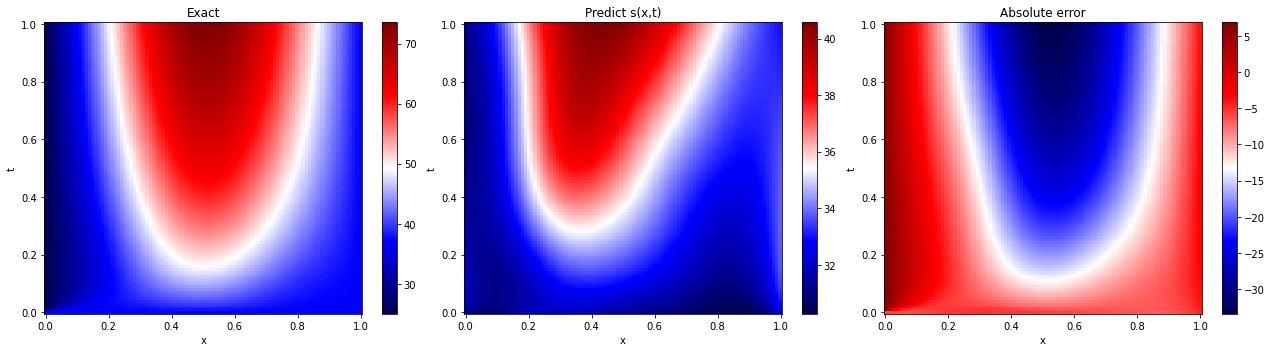

In [65]:
# Plot
fig = plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.pcolor(XX,TT, S_test, cmap='seismic')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Exact')
plt.tight_layout()

plt.subplot(1,3,2)
plt.pcolor(XX,TT, S_pred, cmap='seismic')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predict s(x,t)')
plt.tight_layout()

plt.subplot(1,3,3)
plt.pcolor(XX,TT, S_pred - S_test, cmap='seismic')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Absolute error')
plt.tight_layout()
plt.show()

In [29]:
# Train
model.train(bcs_dataset, res_dataset, nIter=200000)
FILE_NAME = "/home/aroy-admin/UT_Research/Operator_Learning/Operator_Learning/models/experimentL5_NP128_re.eqx"
eqx.tree_serialise_leaves(path_or_file=FILE_NAME,pytree=model)

  0%|          | 100/200000 [00:21<11:49:08,  4.70it/s, Loss=1100.6024532774063, loss_bcs=1083.5575096471327, loss_physics=17.044943630273618]


KeyboardInterrupt: 

Test of tensorboard

In [659]:
jax.profiler.stop_server()

100%|██████████| 200/200 [00:07<00:00, 26.31it/s, Loss=0.0016826354015772441, loss_bcs=0.0005565544472590933, loss_physics=0.0011260809543181508]


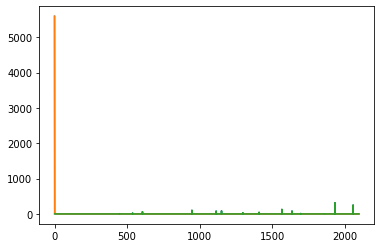

In [657]:
import jax.profiler
# jax.profiler.start_server(9999)

model.train(bcs_dataset, res_dataset, nIter=200)

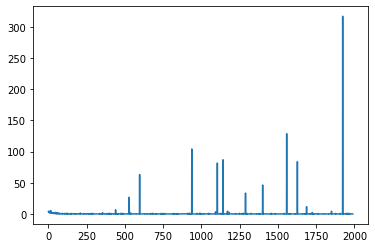

In [633]:
plt.plot(model.loss_log[10:])

In [17]:
model_loaded = eqx.tree_deserialise_leaves(path_or_file="/home/aroy-admin/UT_Research/Operator_Learning/Operator_Learning/models/experimentL5_NP128.eqx", like=model)

In [48]:
param_count = sum(x.size for x in jax.tree_util.tree_leaves(params))
param_count

195362

In [743]:
u_test.shape

(1000000, 100)

In [733]:
y_test[0:100,:].shape

(100, 2)

In [771]:
np.max(s_test)

Array(82.37472, dtype=float32)

In [774]:
s_pred = model.predict_s(params, u_test, y_test)
error_s = np.linalg.norm(s_test - s_pred) / np.linalg.norm(s_test) 
print(error_s)

37.4656


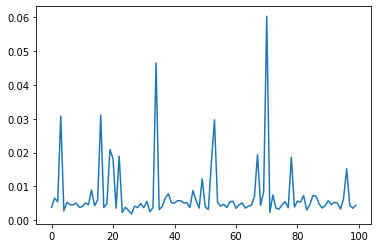

In [63]:
# Testing loss

inference_model = eqx.nn.inference_mode(model)

m = 100
N_test = 100 # number of input samples
key = random.PRNGKey(275)
P_test = 100
Nx = m
Nt = m
keys = random.split(key, N_test)

config.update("jax_enable_x64", True)
u_test, y_test, s_test = vmap(generate_one_test_data, (0, None))(keys, P_test)

#Reshape Data
# u_test = np.float32(u_test.reshape(N_test * P_test**2 * 10,-1))
# y_test = np.float32(y_test.reshape(N_test * P_test**2 * 10,-1))
# s_test = np.float32(s_test.reshape(N_test * P_test**2 * 10,-1))

u_test = np.float32(u_test.reshape(N_test * P_test**2,-1))
y_test = np.float32(y_test.reshape(N_test * P_test**2,-1))
s_test = np.float32(s_test.reshape(N_test * P_test**2,-1))


params = model.get_params(model.opt_state)
x = np.linspace(0, 1, Nx)
t = np.linspace(0, 1, Nt)
XX, TT = np.meshgrid(x, t)

error_test = []
for k in range(N_test):
    s_test_ = s_test[k*P_test**2:(k+1)*P_test**2,:]
    u_test_ = u_test[k*P_test**2:(k+1)*P_test**2,:]
    y_test_ = y_test[k*P_test**2:(k+1)*P_test**2,:]
    S_test = griddata(y_test_, s_test_.flatten(), (XX,TT), method='cubic')

    s_pred = inference_model.predict_s(params, u_test_, y_test_)
    S_pred = griddata(y_test_, s_pred.flatten(), (XX,TT), method='cubic')
    error_s = np.linalg.norm(S_test - S_pred) / np.linalg.norm(S_test) 
    error_test.append(error_s)

testing_loss = np.stack(error_test)
plt.plot(testing_loss)
test_loss_mean = np.mean(testing_loss)

In [50]:
np.max(s_pred)

Array(108.25075, dtype=float32)

In [57]:
# Testing one instance for visualization
inference_model = eqx.nn.inference_mode(model)
N_test = 1 # number of input samples
key = random.PRNGKey(570)
P_test = 100
Nx = m
keys = random.split(key, N_test)

config.update("jax_enable_x64", True)
u_test, y_test, s_test = vmap(generate_one_test_data, (0, None))(keys, P_test)

#Reshape Data
# u_test = np.float32(u_test.reshape(N_test * P_test**2 * 10,-1))
# y_test = np.float32(y_test.reshape(N_test * P_test**2 * 10,-1))
# s_test = np.float32(s_test.reshape(N_test * P_test**2 * 10,-1))

u_test = np.float32(u_test.reshape(N_test * P_test**2,-1))
y_test = np.float32(y_test.reshape(N_test * P_test**2,-1))
s_test = np.float32(s_test.reshape(N_test * P_test**2,-1))

# Generate a uniform mesh
x = np.linspace(0, 1, Nx)
t = np.linspace(0, 1, Nt)
XX, TT = np.meshgrid(x, t)

s_pred = inference_model.predict_s(params, u_test, y_test)
S_pred = griddata(y_test, s_pred.flatten(), (XX,TT), method='cubic')
S_test = griddata(y_test, s_test.flatten(), (XX,TT), method='cubic')
S_error = S_test - S_pred

In [58]:
#Compute the Error
error_s = np.linalg.norm(S_test - S_pred) / np.linalg.norm(S_test)
print(error_s)

0.009117749003212812


<Figure size 720x1440 with 0 Axes>

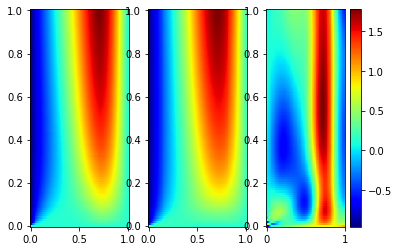

In [225]:
plt.figure(figsize=(10,20))
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.pcolor(XX,TT,S_test,cmap='jet')
ax2.pcolor(XX,TT,S_pred,cmap='jet')
cp = ax3.pcolor(XX,TT,S_error,cmap='jet')
fig.colorbar(cp)

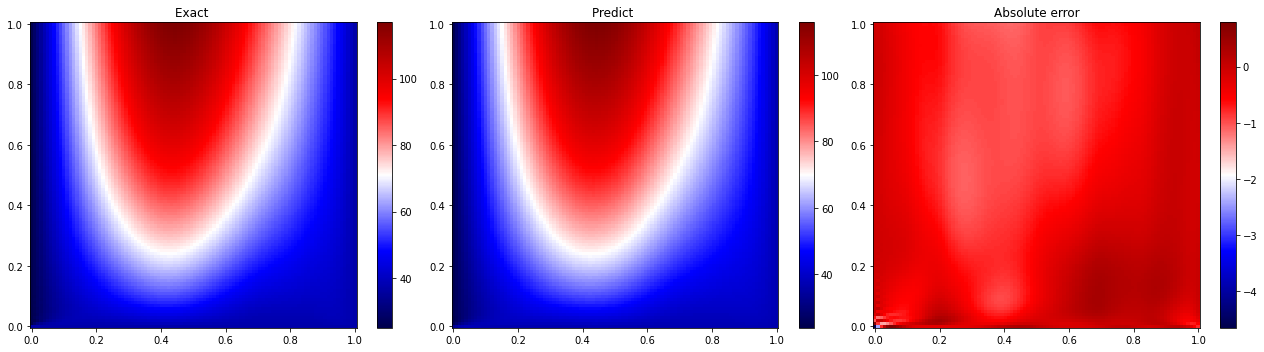

In [59]:
# Plot
fig = plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.pcolor(XX,TT, S_test, cmap='seismic')
plt.colorbar()
plt.xlabel('')
plt.ylabel('')
plt.title('Exact ')
plt.tight_layout()

plt.subplot(1,3,2)
plt.pcolor(XX,TT, S_pred, cmap='seismic')
plt.colorbar()
plt.xlabel('')
plt.ylabel('')
plt.title('Predict ')
plt.tight_layout()

plt.subplot(1,3,3)
plt.pcolor(XX,TT, S_pred - S_test, cmap='seismic')
plt.colorbar()
plt.xlabel('')
plt.ylabel('')
plt.title('Absolute error')
plt.tight_layout()
plt.show()

In [ ]:
class BHTnet(eqx.Module):
    layers: list

    def __init__(self, input_features, output_features, num_projection, key, num_layers):
        subkeys = jr.split(key, 15)
        self.layers = []

        for _ in range(num_layers):
            self.layers.append(MLPLayer(input_features, output_features, num_projection, factor=4))


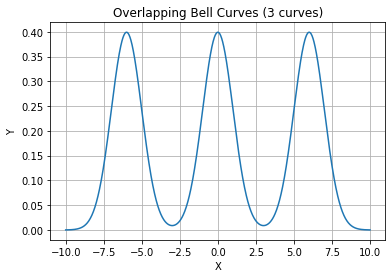

In [442]:
import numpy as np
import matplotlib.pyplot as plt

def bell_curve(x, mean, std_dev):
    # Standard Gaussian (bell curve) probability density function
    return 1 / (std_dev * np.sqrt(2 * np.pi)) * np.exp(-(x - mean)**2 / (2 * std_dev**2))

def overlapping_bell_curves(x, num_curves, peak_positions, std_dev):
    y = np.zeros_like(x)
    for i in range(num_curves):
        y += bell_curve(x, peak_positions[i], std_dev)
    return y

# Parameters
x = np.linspace(-10, 10, 1000)  # Range of x values
num_curves = 3  # Number of bell curves to overlap
peak_positions = [-6, 0, 6]  # Mean positions of the bell curves
std_dev = 1  # Standard deviation for all bell curves

# Generate overlapping bell curves
y = overlapping_bell_curves(x, num_curves, peak_positions, std_dev)

# Plot the result
plt.plot(x, y)
plt.title(f'Overlapping Bell Curves ({num_curves} curves)')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()

In [ ]:
import json

import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jr


def make(*, key, size, width, depth, use_tanh=False):
    if use_tanh:
        activation = jnp.tanh
    else:
        activation = jax.nn.relu
    # (This is not meant to be a realistically useful model.)
    return eqx.nn.MLP(
        in_size=size,
        out_size=1,
        width_size=width,
        depth=depth,
        activation=activation,
        key=key,
    )


hyperparameters = {"size": 5, "width": 10, "depth": 3, "use_tanh": True}
model = make(key=jr.PRNGKey(0), **hyperparameters)

def save(filename, hyperparams, model):
    with open(filename, "wb") as f:
        hyperparam_str = json.dumps(hyperparams)
        f.write((hyperparam_str + "\n").encode())
        eqx.tree_serialise_leaves(f, model)


save("model.eqx", hyperparameters, model)

def load(filename):
    with open(filename, "rb") as f:
        hyperparams = json.loads(f.readline().decode())
        model = make(key=jr.PRNGKey(0), **hyperparams)
        return eqx.tree_deserialise_leaves(f, model)


newmodel = load("model.eqx")

# Check that it's loaded correctly:
assert model.layers[1].weight[2, 2] == newmodel.layers[1].weight[2, 2]

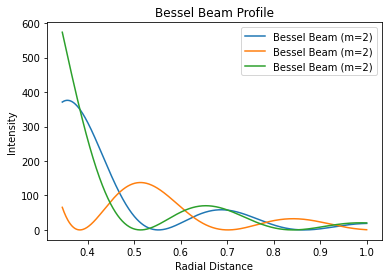

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jv
import jax

def bessel_beam_profile(r, w0, m):
    """
    Generate a Bessel beam profile.

    Parameters:
    - r: Radial distance from the beam axis
    - w0: Waist of the Bessel beam
    - m: Order of the Bessel function

    Returns:
    - Intensity profile of the Bessel beam at the given radial distance
    """

    w = w0 * np.maximum(0.0, np.sqrt(1 + (m * r / w0)**2))  # Bessel beam width
    intensity = np.zeros_like(r)
    intensity = 10000*(2 * jax.scipy.special.bessel_jn(m * r / w0, v=m) / (m * r / w0))**2 # Bessel beam intensity
    return (intensity * np.exp(-(r / w)**2)) # Gaussian envelope

# Generate radial coordinates
r = np.linspace(0, 1, 1000)

# Set Bessel beam parameters
w0 = 0.2  # Waist of the Bessel beam
m = 2   # Order of the Bessel function

# Calculate Bessel beam intensity profile
intensity_profile = bessel_beam_profile(r, w0, m)

# Plot the Bessel beam profile
plt.plot(r, intensity_profile.T, label=f'Bessel Beam (m={m})')
plt.xlabel('Radial Distance')
plt.ylabel('Intensity')
plt.title('Bessel Beam Profile')
plt.legend()
plt.show()


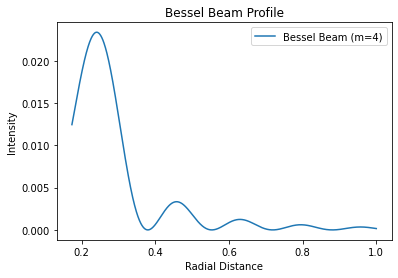

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jv
import jax

def bessel_beam_profile(r, w0, m):
    """
    Generate a Bessel beam profile.

    Parameters:
    - r: Radial distance from the beam axis
    - w0: Waist of the Bessel beam
    - m: Order of the Bessel function

    Returns:
    - Intensity profile of the Bessel beam at the given radial distance
    """

    w = w0 * np.maximum(0.0, np.sqrt(1 + (m * r / w0)**2))  # Bessel beam width
    intensity = np.zeros_like(r)
    intensity = (2 * jax.scipy.special.bessel_jn(m * r / w0, v=m) / (m * r / w0))**2 # Bessel beam intensity
    return (intensity * np.exp(-(r / w)**2)).T[:,-1]  # Gaussian envelope

# Generate radial coordinates
r = np.linspace(0, 1, 1000)

# Set Bessel beam parameters
w0 = 0.2  # Waist of the Bessel beam
m = 4   # Order of the Bessel function

# Calculate Bessel beam intensity profile
intensity_profile = bessel_beam_profile(r, w0, m)

# Plot the Bessel beam profile
plt.plot(r, intensity_profile, label=f'Bessel Beam (m={m})')
plt.xlabel('Radial Distance')
plt.ylabel('Intensity')
plt.title('Bessel Beam Profile')
plt.legend()
plt.show()

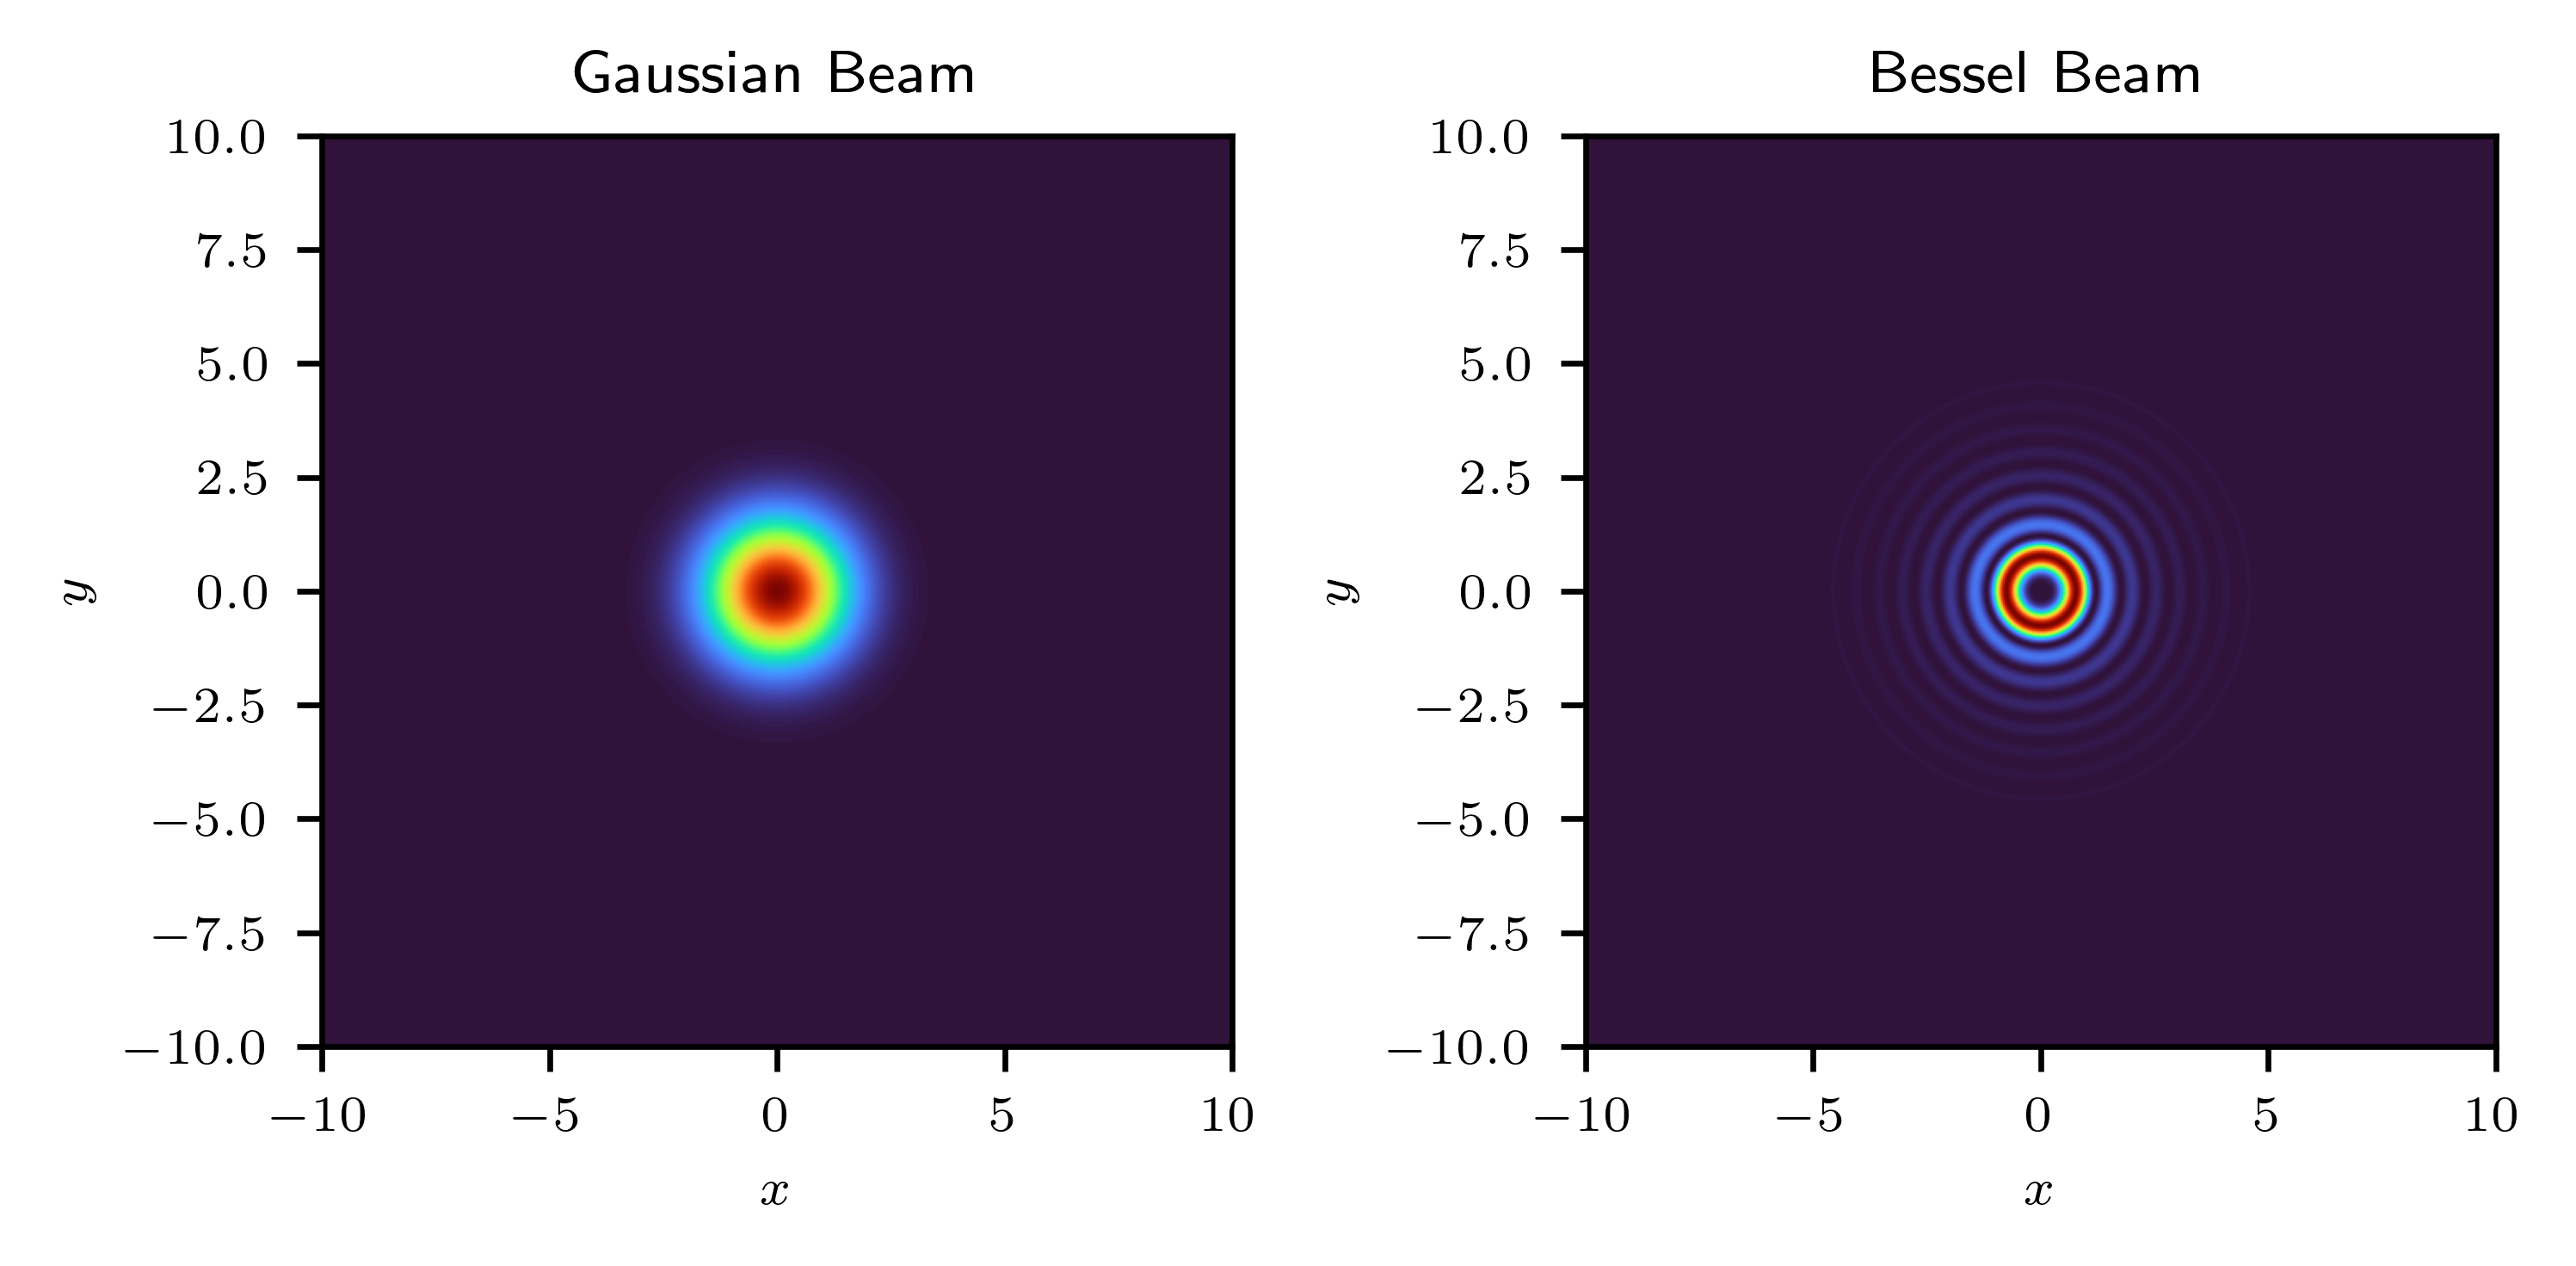

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jn
from scipy.constants import pi

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 14})

def gaussian_beam_intensity(x, y, w0):
    r_squared = x**2 + y**2
    return np.exp(-2 * r_squared / w0**2)

def bessel_beam_intensity(x, y, m):
    r = np.sqrt(x**2 + y**2)
    return np.abs(2 * jn(m, 2 * pi * r))**2 / (pi * r)**2

# Generate spatial coordinates
x = np.linspace(-10, 10, 500)
y = np.linspace(-10, 10, 500)
X, Y = np.meshgrid(x, y)

# Set parameters
w0_gaussian = 2.0  # Waist parameter for Gaussian beam
m_bessel = 4       # Order of Bessel function

# Calculate intensity profiles
intensity_gaussian = gaussian_beam_intensity(X, Y, w0_gaussian)
intensity_bessel = bessel_beam_intensity(X, Y, m_bessel)

# Plot the intensity profiles
fig, axs = plt.subplots(1, 2, figsize=(10,5), dpi=600)

axs[0].imshow(intensity_gaussian, extent=(x.min(), x.max(), y.min(), y.max()), cmap='turbo', origin='lower')
axs[0].set_title('Gaussian Beam')
axs[0].set_xlabel('$x$')
axs[0].set_ylabel('$y$')

axs[1].imshow(intensity_bessel, extent=(x.min(), x.max(), y.min(), y.max()), cmap='turbo', origin='lower')
axs[1].set_title('Bessel Beam')
axs[1].set_xlabel('$x$')
axs[1].set_ylabel('$y$')

plt.tight_layout()
plt.show()


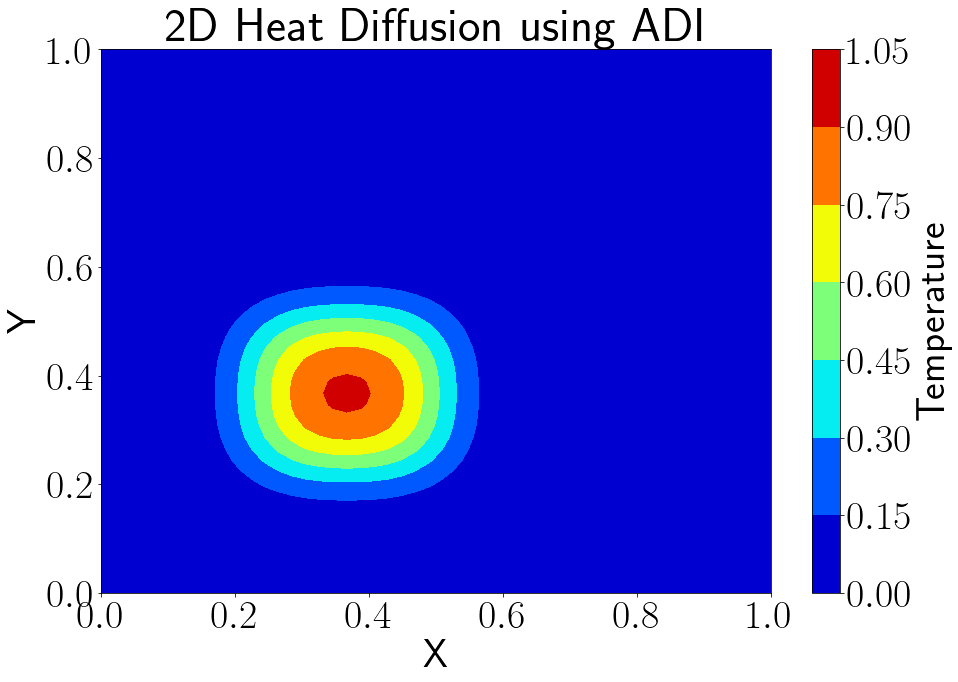

In [21]:
# ADI method for 2D heat diffusion equation

import numpy as np
import matplotlib.pyplot as plt

# Parameters
Lx = 1.0  # Length of the domain in the x-direction
Ly = 1.0  # Length of the domain in the y-direction
Nx = 50   # Number of grid points in the x-direction
Ny = 50   # Number of grid points in the y-direction
T = 0.2   # Total time
Nt = 100  # Number of time steps
alpha = 0.01  # Thermal diffusivity
dx = Lx / (Nx - 1)
dy = Ly / (Ny - 1)
dt = T / Nt

# Initial conditions
u0 = np.zeros((Nx, Ny))
u0[Nx // 4:Nx // 2, Ny // 4:Ny // 2] = 1.0  # Initial condition: Square wave in the center

# ADI method
def adi(u0, Nx, Ny, dx, dy, dt, alpha, Nt):
    u = np.copy(u0)
    Ax = alpha * dt / dx**2
    Ay = alpha * dt / dy**2

    # ADI loop
    for _ in range(Nt):
        # X direction sweep
        for j in range(1, Ny - 1):
            a = -Ax / 2
            b = 1 + Ax
            c = -Ax / 2
            d = np.zeros(Nx)
            d[1:-1] = (Ay / 2) * u[:-2, j] + (1 - Ay) * u[1:-1, j] + (Ay / 2) * u[2:, j]
            d[0] = (Ay / 2) * u[0, j] + (1 - Ay) * u[1, j] + (Ay / 2) * u[2, j]
            d[-1] = (Ay / 2) * u[-1, j] + (1 - Ay) * u[-2, j] + (Ay / 2) * u[-3, j]
            u[:, j] = np.linalg.solve(np.diag(a * np.ones(Nx - 1), -1) + np.diag(b * np.ones(Nx), 0) + np.diag(c * np.ones(Nx - 1), 1), d)

        # Y direction sweep
        for i in range(1, Nx - 1):
            a = -Ay / 2
            b = 1 + Ay
            c = -Ay / 2
            d = np.zeros(Ny)
            d[1:-1] = (Ax / 2) * u[i, :-2] + (1 - Ax) * u[i, 1:-1] + (Ax / 2) * u[i, 2:]
            d[0] = (Ax / 2) * u[i, 0] + (1 - Ax) * u[i, 1] + (Ax / 2) * u[i, 2]
            d[-1] = (Ax / 2) * u[i, -1] + (1 - Ax) * u[i, -2] + (Ax / 2) * u[i, -3]
            u[i, :] = np.linalg.solve(np.diag(a * np.ones(Ny - 1), -1) + np.diag(b * np.ones(Ny), 0) + np.diag(c * np.ones(Ny - 1), 1), d)

    return u

# Solve using ADI
u_final = adi(u0, Nx, Ny, dx, dy, dt, alpha, Nt)

# Plot the solution
X, Y = np.meshgrid(np.linspace(0, Lx, Nx), np.linspace(0, Ly, Ny))
plt.figure(figsize=(15, 10))
plt.contourf(X, Y, u_final.T, cmap='jet')
plt.colorbar(label='Temperature')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Heat Diffusion using ADI')
plt.show()
